# PROGETTO MACHINE LEARNING: PHISING URL RECOGNITION

## Abstract: Rilevamento di URL di Phishing tramite Tecniche di Dimensionality Reduction e Apprendimento Supervisionato

Il presente studio analizza l'efficacia di diversi paradigmi di **Machine Learning** nella classificazione di URL malevoli, utilizzando il dataset ad alte prestazioni **Web Page Phishing Dataset**. 

La ricerca affronta la sfida della sicurezza informatica moderna attraverso un confronto sistematico tra modelli basati su iperpiani di separazione e architetture ensemble, operando su uno spazio vettoriale composto da **89 feature** estratte (caratteristiche lessicali, statistiche e comportamentali degli URL).

### Metodologia e Pre-processing

Data la complessità e la multidimensionalità del dataset, il workflow implementato non si limita all'addestramento diretto, ma prevede una fase critica di ottimizzazione del dato:

1. **Analidi della skewness e magnitudo delle feature:** per garantire che l'ampiezza delle scale delle 89 feature non influenzi negativamente i gradienti dei modelli.
2. **Scaling** per garantire che tutte le feature convergano ad una Gaussiana Standard, ovvero $\mathcal N(0,1)$
3. **PCA** per ridurre la dimensionalità del dataset

### Classificatori a Confronto

Il task di classificazione binaria viene risolto attraverso due approcci algoritmici distinti:

* **Support Vector Machines (SVM):** esplorate nelle varianti con **Kernel Lineare**, **Polinomiale (Poly)** e **Radial Basis Function (RBF)**, per testare la capacità del modello di mappare i dati in spazi a dimensionalità superiore.
* **Metodi Ensemble:** implementati per massimizzare la robustezza predittiva tramite strategie di **Bagging** (**Random Forest**) e **Boosting** (**AdaBoost** e **Gradient Boosting**). Questi modelli sono stati scelti per la loro intrinseca capacità di gestire relazioni non lineari e per la resistenza all'overfitting rispetto ai singoli alberi di decisione.

## Baseline

Come Baseline, sono stati scelti due modelli:
1. **DummyClassifier** : la baseline più semplice fra tutte
2. **LogisticRegression** : modello più semplice, ci servirà da base reale (farà anche da **strong baseline**) 

In [1]:
# Rimuovi o commenta la riga sotto
# %matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew

# Visualizzazione
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# Scikit-learn: Preprocessing e Trasformazioni
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Scikit-learn: Modelli e Validazione
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Scikit-learn: Metriche e Ispezione
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, precision_recall_fscore_support
)
from sklearn.inspection import permutation_importance  

print("Librerie caricate con successo!")

Librerie caricate con successo!


In [2]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

In [3]:
data = pd.read_csv('Dataset/web-page-phishing/dataset_phishing.csv')
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
data.shape

(11430, 89)

In [5]:
data.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [6]:
data.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000


---

## Analisi delle feature

Di seguito riportiamo una breve descrizione di ogni feature presente nel dataset

**osservazione**: non tutte le descrizioni erano presenti nel file del dataset, alcune di esse sono frutto di un mio ragionamento e pertanto potrebbero non essere corrette

### 1. Feature Strutturali dell'URL

Queste variabili analizzano la composizione testuale dell'indirizzo web.

* **url**: L'indirizzo URL completo analizzato.
* **length_url / length_hostname**: Lunghezza totale dell'URL e del solo nome dell'host.
* **ip**: Variabile binaria; indica se nell'URL è presente un indirizzo IP al posto del nome a dominio (spesso usato nel phishing).
* **nb_dots / nb_hyphens / nb_at / nb_qm / nb_and / nb_or / nb_eq / nb_underscore / nb_tilde / nb_percent / nb_slash / nb_star / nb_colon / nb_comma / nb_semicolumn / nb_dollar / nb_space**: Conteggio di caratteri speciali (punti, trattini, chiocciole, punti interrogativi, ecc.) presenti nell'URL.
* **nb_www / nb_com / nb_dslash**: Conteggio delle stringhe "www", ".com" e del doppio slash "//" all'interno del percorso.
* **http_in_path**: Presenza della stringa "http" all'interno del percorso dell'URL (tecnica per mascherare URL malevoli).
* **https_token**: Indica se il token "https" è presente nella parte dell'host (non nel protocollo).
* **ratio_digits_url / ratio_digits_host**: Rapporto tra caratteri numerici e lunghezza totale rispettivamente dell'URL e dell'host.
* **punycode**: Indica se l'URL utilizza la codifica Punycode per caratteri speciali (es. domini con accenti).
* **port**: Indica se nell'URL è specificata una porta non standard.

### 2. Feature del Dominio e Sottodomini

* **tld_in_path / tld_in_subdomain**: Presenza di un TLD (es. .com, .net) nel percorso o nel sottodominio.
* **abnormal_subdomain**: Indica se la struttura del sottodominio è anomala.
* **nb_subdomains**: Numero di sottodomini presenti.
* **prefix_suffix**: Presenza di trattini nel nome a dominio per separare prefissi o suffissi.
* **random_domain**: Indica se il dominio sembra generato casualmente.
* **shortening_service**: Indica se viene utilizzato un servizio di abbreviazione URL (es. bit.ly).

### 3. Feature Lessicali (Parole nell'URL)

* **length_words_raw**: Numero totale di parole identificate nell'URL.
* **shortest_words_raw / longest_words_raw**: Lunghezza della parola più corta e più lunga nell'intero URL.
* **shortest_word_host / longest_word_host**: Lunghezza della parola più corta e più lunga nell'host.
* **avg_words_raw / avg_word_host / avg_word_path**: Lunghezza media delle parole nell'URL, nell'host e nel percorso.
* **phish_hints**: Conteggio di parole tipicamente usate negli attacchi phishing (es. "login", "update", "secure").

### 4. Feature del Contenuto della Pagina (HTML/JS)

* **nb_hyperlinks**: Numero totale di link presenti nella pagina web.
* **ratio_intHyperlinks / ratio_extHyperlinks / ratio_nullHyperlinks**: Percentuale di link che puntano allo stesso dominio, a domini esterni o che sono vuoti/nulli.
* **nb_extCSS**: Numero di file CSS caricati da domini esterni.
* **ratio_intRedirection / ratio_extRedirection**: Rapporto di reindirizzamenti interni ed esterni.
* **login_form**: Presenza di form di inserimento credenziali (input di tipo password).
* **external_favicon**: Indica se la favicon (l'icona del sito) è caricata da un dominio esterno.
* **links_in_tags**: Percentuale di link presenti nei tag (meta, script, link) rispetto al totale.
* **submit_email**: Indica se il form invia i dati direttamente a una mail (tramite `mailto:`).
* **ratio_intMedia / ratio_extMedia**: Rapporto di file multimediali (immagini, video) interni ed esterni.
* **iframe / popup_window**: Presenza di tag iframe o script che generano finestre popup.
* **safe_anchor**: Percentuale di ancore (`<a>`) che puntano a URL sicuri o allo stesso dominio.
* **onmouseover / right_clic**: Presenza di script che intercettano il movimento del mouse o disabilitano il tasto destro.
* **empty_title / domain_in_title**: Indica se il titolo della pagina è vuoto o se contiene il nome a dominio.

### 5. Feature Esterne e di Reputazione

* **whois_registered_domain**: Indica se il dominio è regolarmente registrato nei database WHOIS.
* **domain_registration_length**: Durata (in giorni) della registrazione del dominio.
* **domain_age**: Età del dominio in giorni (i domini recenti sono più sospetti).
* **web_traffic**: Rilevanza del sito in base al traffico web (es. ranking Alexa).
* **dns_record**: Presenza di record DNS validi per il dominio.
* **google_index**: Indica se la pagina è indicizzata su Google.
* **page_rank**: Valore del PageRank del sito (misura dell'autorevolezza).

### Target

* **status**: La variabile da predire; indica se l'URL è **legitimate** (sicuro) o **phishing** (malevolo).

In [7]:
# con dataset dataset_phishing.csv

print('# URL leggittime:', len(data.loc[data['status']=='legitimate']))
print('# URL phising:', len(data.loc[data['status']=='phishing']))
print('Percentuale phising:', len(data.loc[data['status']=='phishing']) / (len(data.loc[data['status']=='legitimate']) + len(data.loc[data['status']=='phishing']))*100,'%')
print('Percentuale non phising:', len(data.loc[data['status']=='legitimate']) / (len(data.loc[data['status']=='legitimate']) + len(data.loc[data['status']=='phishing']))*100,'%')

# URL leggittime: 5715
# URL phising: 5715
Percentuale phising: 50.0 %
Percentuale non phising: 50.0 %


In [8]:
# get all columns that have value != numeric
non_numeric_columns = data.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_columns

['url', 'status']

In [9]:
numeric_columns = data.select_dtypes(include=['number']).columns.tolist()
numeric_columns

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extHyp

In [10]:
tmp = data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


# Analisi delle distribuzioni delle feature

## Target Label Encoding

Prima di tutto notiamo che la feature `url` non serve nella trattazione del nostro problema, pertanto possiamo rimuoverla

Utilizziamo inoltre una tecnica di Labeling chiamata **LabelEnconder** di `scikit.learn`, che ci permette di trasformare la colonna **status** (che corrisponde alla nostra colonna dei target `y`) in tutti valori numerici `0/1`.

La mappatura della feature `status` avviene nel seguente modo:
- Lo status = `legitimate` viene mappato nel numero $0$
- Lo status = `phishing` viene mappato nel numero $1$

In [11]:
data.drop('url', axis=1, inplace=True)  # Rimuovi la colonna 'url' se non necessaria
non_numeric_columns.remove('url')
# gestiamo i valori vuoti
data['status'].fillna("NONE", inplace=True)
# inizializzamo l'encoder di sklearn
le = LabelEncoder()
# fit + transform
data['status'] = le.fit_transform(data['status'])

In [12]:
data

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,45,17,0,2,0,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,0
11426,84,18,0,5,0,1,1,0,0,1,...,1,0,0,211,6728,0,0,1,0,1
11427,105,16,1,2,6,0,1,0,0,1,...,0,0,0,2809,8515,8,0,1,10,0
11428,38,30,0,2,0,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,0


## Separazione delle feature

Andiamo ora ad analizzare le nostre feature, dividendole in due gruppi
- feature **numeriche**: feature che indicano misurazioni/conteggi; possono essere *continue* o *discrete*
- feature **categoriali**: feature che descrivono caratteristiche qualitative, etichette o gruppi non numerici; possono essere identificate con valori numerici, anche se non hanno un significato numerico intrinseco; possono essere dei flag booleani e indicati con $0/1$ nel dataset.

In [13]:
"""
Separa le feature in numeriche e categoriali.

Args:
    data: Il dataframe da analizzare.
    target_col: Nome della colonna target.
    id_col: Nome della colonna identificativo (URL).
    threshold: Numero massimo di valori unici per considerare una feature come categoriale.
"""
# Escludiamo le colonne che non sono feature di input
features_df = data.drop(columns=['status'])

categorical_features = []
numerical_features = []

for col in features_df.columns:
    # Se la colonna è di tipo 'object' o ha pochi valori unici (es. flag 0/1), è categoriale
    if features_df[col].dtype == 'object' or features_df[col].nunique() <= 2:
        categorical_features.append(col)
    else:
        numerical_features.append(col)
        
print(len(categorical_features), "feature categoriali:", categorical_features)
print(len(numerical_features), "feature numeriche:", numerical_features)

37 feature categoriali: ['ip', 'nb_or', 'nb_tilde', 'nb_star', 'nb_dslash', 'https_token', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_external_redirection', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'login_form', 'external_favicon', 'submit_email', 'sfh', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'empty_title', 'domain_in_title', 'domain_with_copyright', 'whois_registered_domain', 'dns_record', 'google_index']
50 feature numeriche: ['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'http_in_path', 'ratio_digits_url', 'ratio_digits_host', 'nb_subdomains', 'nb_redirection', 'length_words_raw', '

Visualizziamo la distribuzione quindi delle feature numeriche in relazione allo status

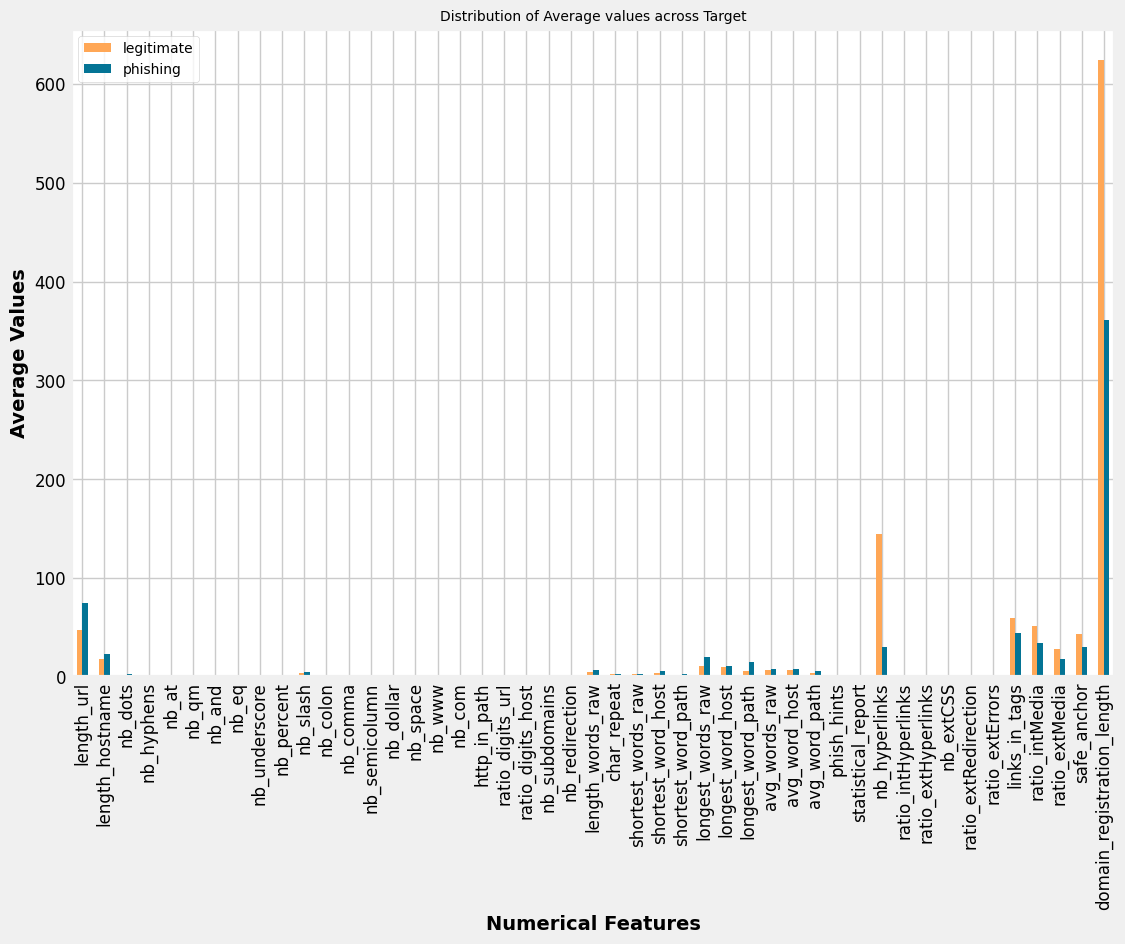

In [14]:
df_distr =data.groupby('status')[numerical_features].mean().reset_index().T
df_distr.rename(columns={0:'legitimate',1:"phishing"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['legitimate','phishing']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()


Osservazioni
- Più grande è la feature `lenght_url`, più è probabile che la url in questione sia `Phishing`
- C'è una differenza molto elevata per la feature `nb_hyperlinks`. Più grande significa più probabile che sia `Legitimate`
- L'alto volume delle feature `links_in_tags` ,`safe_anchor` segnala che la URL sia più propensa vero lo status `Legitmate`
- Similmente alla feature `lenght_url`, più la feature `domain_registration_lenght` è elevata e più è probabile che il sito sia `Legitimate`

Visualizziamo la distribuzione quindi delle feature categoriali in relazione allo status

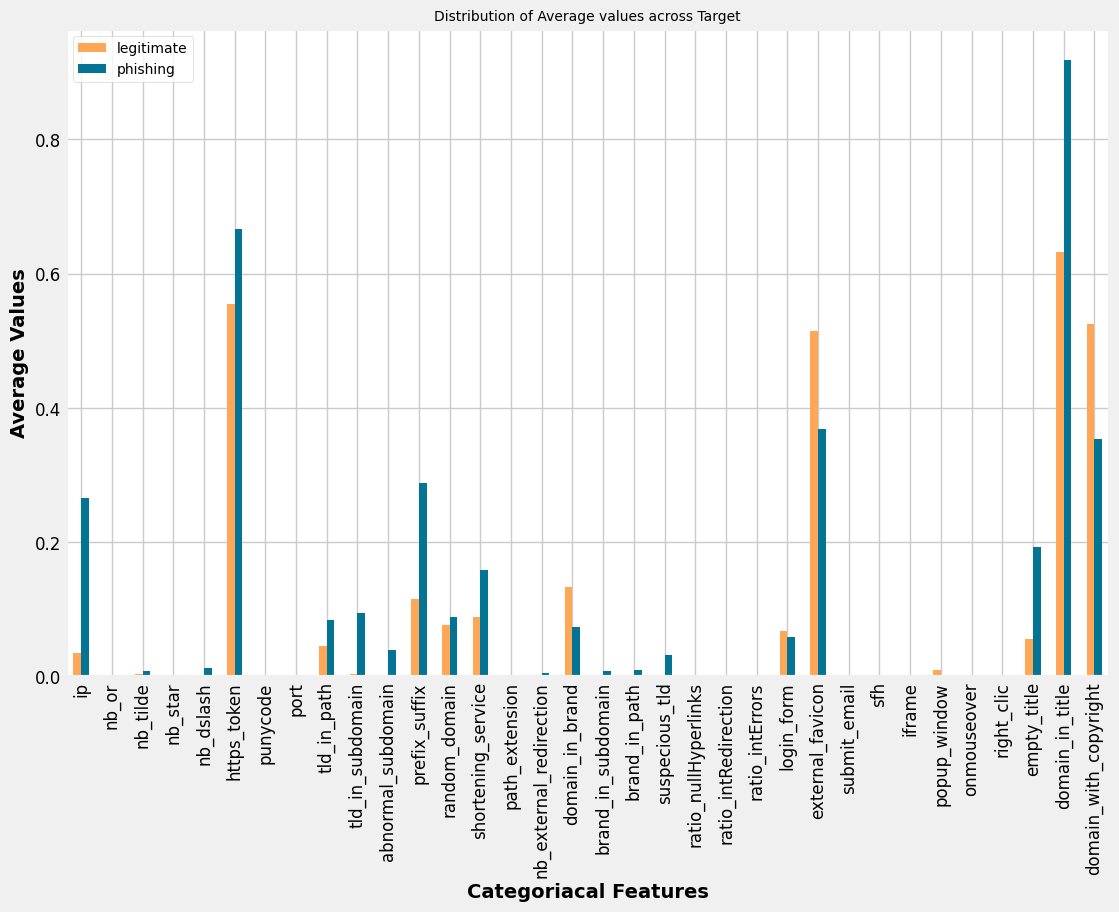

In [15]:
df_distr =data.groupby('status')[categorical_features].mean().reset_index().T
df_distr.rename(columns={0:'legitimate',1:"phishing"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['legitimate','phishing']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Categoriacal Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()


Osservazioni
- Più grande è la feature `domain_in_title`, più è probabile che la url in questione sia `Phishing`
- C'è una differenza molto elevata per la feature `prefix_suffix`. Più grande significa più probabile che sia `Phishing`
- Similmente alla feature `prefix_suffix`, più la feature `ip` è elevata e più è probabile che il sito sia `Phishing`

## Skewness & Magnitudo delle feature

Analizziamo ora le differenze fra le varie feature.

Ci concentreremo per lo più su due fattori fondamentali, che sono:
- **skewness** delle feature
- **magnitudo** delle feature

### Skenwess : Definizione e Soluzione

La skewness di una feature ci indica quanto la distribuzione di quella feature ***si discosta*** da una distribuzione normale (la classica "campana" Gaussiana)

Possiamo identificare $3$ tipi di skewness nelle feature, che sono

| Tipo                    | Descrizione                                                                                                 | Relazione tra Media e Mediana |
|-------------------------|-------------------------------------------------------------------------------------------------------------|-------------------------------|
| Positiva (Right-skewed) | La "coda" della distribuzione è più lunga verso destra. La maggior parte dei dati è concentrata a sinistra. | Media > Mediana               |
| Zero (Symmetrical)      | La distribuzione è perfettamente simmetrica (come una Gaussiana).                                           | Media ≈ Mediana               |
| Negativa (Left-skewed)  | La "coda" è più lunga verso sinistra. La maggior parte dei dati è concentrata a destra.                     | Media < Mediana               |

Perchè questo fattore è fondamentale nella trattazione del nostro problema? 

Perchè molti modelli di Machine Learning, tra cui il modello **SVM** (scelto per la risoluzione del task), sono sensibili all'asimmetria delle feature; questo potrebbe portare a situazioni spiacevoli quali:
- **Distorsione del/dei modello/i**
- **Performance ridotte**
- **Instabilità**

Per tali ragioni, verrà eseguito un controllo/calcolo dell'asimmetria delle feature presenti nel dataset. A quelle feature che hanno skewness elevata verrà applicata la tecnica della **log-trasformazione** ($log1p$ di scikit.learn)

Questa tecnica permette di applicare il logaritmo naturale $\ln(x)$ ai valori di una feature; questo permette di:
- Ridurre la skewness positiva
- Stabilizza la varianza

Inoltre, dato che ci sono valori vicini allo zero, e altri che sono esattamente zero, si è optato per l'applicazione di $\log(1+x)$ piuttosto che $\log(x)$

### Magnitudo: Definizione e Soluzione

Il magnitudo di una feature indica la grandezza dei valori di quella feature (ovvero la scala di valori).

Perchè questo fattore è di fondamentale trattazione?

Perchè i modelli basati su **distanza** (come il kNN e/o SVM) o su **discesa del gradiente** (come Regressione Lineare e/o Reti Neurali), se addestrati su un dataset avente feature con magnitudo estremamente diversi, potrebbero portare a risultati molto spiacevoli.

Prendiamo come esempio il modello SVM: lui cerca di trovare l'iperpiano che **massimizza il margine** tra le classi.

Se prendiamo due feature $x_1$  (es. reddito) e $x_2$ (es. età) tali per cui $mag(x_1)\gt\gt mag(x_2)$, ($mag(x_i)=$ magnitudo della feature $x_i$) allora la prima dominerà sulla seconda. L'algoritmo quindi "ignorerà" la seconda feature perchè, matematicamente, le sue variazioni sembrano irrilevanti rispetto a quelle del reddito

Per risolvere questo problema si è fatto uso della tecnica di **Standardizzazione (Z-Score Scaling)** di scikit.learn, che trasforma i dati in modo che abbiano **media=0** e **deviazione standard = 1**; cioè comprime i dati in modo che seguano una **distribuzione Gaussiana Standard** $\mathcal N(0,1)$

Vedere appendice [qui](#appendice-spiegazione-standardscaler-di-scikitlearn)

## Train/Test Split

Diviamo il dataset originale in:
- Training Set: insieme di valori del dataset originale con cui verranno addestrati i nostri modelli
- Test Set: insieme di valori del dataset originale, ***separato*** dal training set, con cui verranno valutate le prestazioni e le performance dei nostri modelli

Il test set rappresenta quindi "nuovi" dati per i nostri modello, dati che loro $\textit{NON devono mai vedere}$ prima della fine dell'addestramento.

La divisione avverrà secondo il classico rapporto $80/20$

In [16]:
# --- FASE DI TRAIN/TEST SPLIT ---
X = data.drop('status', axis=1)
y = data['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (9144, 87)
y_train.shape: (9144,)
X_test.shape: (2286, 87)
y_test.shape: (2286,)


## Calcolo Skewness e Magnitudo

Calcoliamo quindi la skenwess e la magintudo delle feature.

Per quanto detto prima, prenderemo in considerazione le feature con skewness maggiore e ne fearemo la log trasformazione.

Poi applicheremo lo StandardScaler a tutte le feature.

Il tutto verrà eseguito tramite il processo `Pipeline` di scikit.learn, in modo da evitare il `Data Leakage` quando faremo la divisione con cross-validation.

In [17]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

skewness = X_train[numeric_features].apply(lambda x: skew(x.dropna()))

skew_threshold = 1.0

skewed_features = [
    col for col in skewness[skewness > skew_threshold].index.tolist()
    if X_train[col].min() >= 0
]

#skewed_features = skewness[skewness > skew_threshold].index.tolist()
non_skewed_features = [col for col in numeric_features if col not in skewed_features]

print("Feature con skew elevata:", skewed_features)
print("Feature senza skew elevata:", non_skewed_features)


Feature con skew elevata: ['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_com', 'nb_dslash', 'http_in_path', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_hyperlinks', 'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection', 'ratio_extErrors', 'login_form', 'ratio_extMedia', 'iframe'

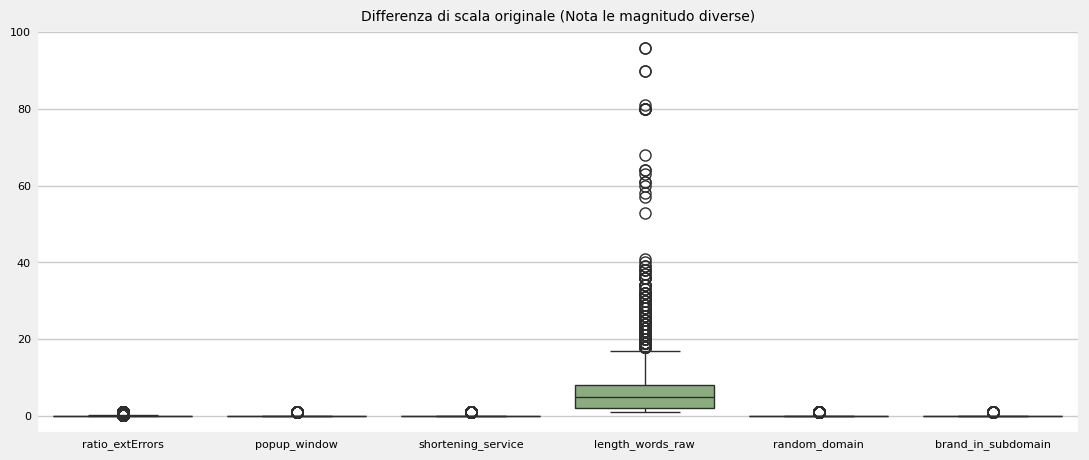

In [18]:
import random
plt.figure(figsize=(12, 5))
sample = X_train[random.sample(list(X_train.columns), k=6)]# + ['web_traffic']]
sns.boxplot(data=sample)
# nb_redirection, nb_eq, google_index, nb_com, links_in_tag, shortest_word_host
#sns.boxplot(data=data[['web_traffic','abnormal_subdomain','nb_hyperlinks','onmouseover']])
plt.title("Differenza di scala originale (Nota le magnitudo diverse)")
plt.show()

## Definizione preprocessor

Definiamo quindi il nostro preprocessor, da inserire in fase di Training all'interno della Pipeline (in modo da garantire che ogni operazione venga fatta correttamente all'interno dei fold, così evitiamo **Data Leakage**)

Il preprocessor avrà quindi la seguente forma:
- alle feature estreme verrà applicato log-trasformazione
- a tutte le feature verrà applicato lo StandardScaler (comprese le feature estreme)

Per implementarlo, applicheremo la funzione **ColumnTransformer**

In [19]:
log_transformer = FunctionTransformer(np.log1p, validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("log", log_transformer, skewed_features),
        ("num", "passthrough", non_skewed_features)
    ]
)


# Training & Evaluation

Dopo aver analizzato e diviso (train/test split) il nostro dataset originale, siamo pronti per addestrare i $2$ modelli descritti all'inizio di questo notebook.

Per ogni modello, verrà applicata una Pipeline contenente:
1) Per SVM - Preprocessor + Scaler + PCA
2) Per RandomForest due versioni, raw e solo con log-trasformazione

Alla fine, dopo aver addestratto tutti i modelli scelti, faremo proprio un confronto qualitativo fra essi, mettendo in luce caratteristiche come:
1) Tempi di addestramento
2) Precisione della predizione
3) F1-score
4) Precision e Recall
5) Deviazione standard ($\sigma$)

Al fine di evitare il più possibile situazioni critiche di overfitting, useremo la tecnica $K$-**fold Cross-validation**, con parametro $K=5$

Perchè questa tecnica?

1) Applicare questa tecnica garantisce la stabilità delle performance e la minimizzazione del bias dovuto alla selezione del training set.
2) Questo approccio divide il training set in $5$ sottogruppi (**fold**): ciclicamente, i vari modelli verranno addestrati su $4$ di essi e validati sul restante.
3) I risultati riportati rappresentano la media aritmetica delle prestazioni ottenute nelle $5$ iterazioni, fornendo una stima più affidabile delle capacità predittiva rispetto al singolo split statico.

Avendo quindi optato per la seguente strategia, eseguiremo **scaling** e **PCA** dentro ogni fold (usando la `Pipeline` di scikit.learn), in modo da evitare il più possibile "Data Leakage", ovvero "iniettare" dati nel validation set

# Definizioni di Precision, Recall e F1-Score

Abbiamo detto che valuteremo, oltre all'accuracy dei modelli, le metriche:
- Precision
- Recall
- F1-Score

Prima di definire rigorosamente le 3 metriche introdotte, definiamo il concetto di `Confusion Matrix` e come questo viene applicato nel calcolo di Precision, Recall e F1-Score

## Confusion Matrix

Sia $$\{(x_i,y_i)\}_{i=1}^{n}$$ il nostro dataset, con:
- $y_i\in\{0,1\}$ il target per l'elemento $i$-esimo del dataset
- $\hat{y}_i\in\{0,1\}$ il target **predetto** per l'elemento $i$-esimo del dataset

Definiamo la **Confusion Matrix** come la matrice
|       | $\hat{y}=0$ | $\hat{y}=1$ |
| ----- | ----------- | ----------- |
| $y=0$ | TN          | FP         |
| $y=1$ | FN         | TP          |


Dove:
- **TP** (True Positives): istanze di phishing correttamente classificate come tali (**Phishing bloccati**)
- **FP** (False Positives): istanze legittime classificate come di phishing (**Falso Allarme**)
- **FN** (False Negatives): istanze di phishing classificate come legittime (**Phishing mancati**)
- **TN** (True Negatives): istanze di siti legittimi correttamente classificate come tali (**Siti sicuri**)

## Precision

Definiamo la `Precision` come la frazione:
$$\boxed{\text{Precision}=\frac{TP}{TP+FP}}$$

Formalmente, la precision di una classe è la **probabilità** che un'istanza sia effettivamente positiva, sapendo che il classificatore l'ha predetta come positiva, ovvero:
$$\text{Precision}=Pr(y=1|\hat{y}=1)$$

## Recall

Definiamo la `Recall` come la frazione:
$$\boxed{\text{Recall}=\frac{TP}{TP+FN}}$$

Formalmente, la recall di una classe è la **probabilità** che il classificatore predica positivo, sapendo che l'istanza è effettivamente positiva, ovvero:
$$\text{Recall}=Pr(\hat{y}=1|y=1)$$

## F1-Score

Definiamo la `F1-Score` come la frazione:
$$\boxed{\text{F1-Score}=2\cdot\frac{\text{Precision}\cdot\text{Recall}}{\text{Precision}+\text{Recall}}}$$

Formalmente, la `F1-score` è la **media armonica** tra precision e recall, ed è massimo solo quando entrambe sono alte.

# Analisi decisionale del problema : Falsi Positivi o Falsi Negativi?

Classificazione binaria:

- Classe (1): URL di phishing
- Classe (0): URL legittimo

Errori possibili:

| Errore                  | Significato                              | Conseguenza reale        |
| ----------------------- | ---------------------------------------- | ------------------------ |
| **False Positive (FP)** | URL legittimo classificato come phishing | Blocco/alert inutile     |
| **False Negative (FN)** | URL phishing classificato come legittimo | Compromissione sicurezza |

**False Negative** (molto grave)

- L’utente clicca su un link malevolo
- Possibile:
    - furto credenziali
    - malware
    - compromissione account
    - danni economici
- Costo elevato e potenzialmente irreversibile

**False Positive** (fastidioso ma accettabile)

- L’utente vede un alert
- L’URL viene bloccato temporaneamente
- Può essere:
    - sbloccato manualmente
    - whitelistato
- Costo basso e reversibile

Data la trattazione del problema, quello che noi vogliamo che sia minimizzato è il numero di **Falsi Negativi**, di conseguenza, la metrica più importante fra tutte sarà la **Recall** della classe di Phishing

Di conseguenza, l'ordine che i nostri modelli dovranno rispettare sarà:

$$\boxed{\text{Recall}\gt\text{F1-score}\gt\text{Precision}}$$

**Recall**: sicurezza

**F1**: compromesso globale

**Precision**: usabilità


---

## Implementazioni funzioni di appoggio

In questa sezione, implementiamo alcune funzioni di appoggio che ci serviranno più avanti

Ad esempio, fra queste funzioni abbiamo quella per calcolare gli iperparametri ottimali del modello, in modo da ottenere la predizione migliore fra tutte

In [21]:
def iperparametri_ott_pipe(pipe, param_grid, X_train, y_train, scoring='f1'):
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=inner_cv,
        return_train_score=True,
        n_jobs=-1,
        scoring=scoring
    )
    
    grid_search.fit(X_train, y_train)
    
    # Estrae i risultati della Cross-Validation per tutte le combinazioni di parametri
    results = grid_search.cv_results_
    
    mean_train_scores = results['mean_train_score'] # media degli scores per il training
    
    mean_test_scores  = results['mean_test_score'] # Media degli scores per il test
    
    params = results['params'] # Parametri testati durante la GridSearch
    
    best_estimator = grid_search.best_estimator_ # Miglior stimatore trovato dalla GridSearch
    
    return {
        "mean_train": mean_train_scores,
        "mean_val": mean_test_scores,
        "params": params,
        "best_estimator": best_estimator,
        "grid": grid_search
    }

In [22]:
def evaluation(model, X, y):
    # Predizioni cross-validated (per CM, ROC, metriche aggregate)
    y_pred = cross_val_predict(model, X, y, cv=5)

    mean_cv = np.mean(y_pred)
    std_cv = np.std(y_pred)
    penalized_score = mean_cv - std_cv

    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary'
    )
    cfm = confusion_matrix(y, y_pred)

    # Accuracy per fold (per std corretta)
    acc_scores = cross_val_score(
        model, X, y, cv=5, scoring='accuracy'
    )

    std_dev = acc_scores.std()

    return acc, precision, recall, f1, cfm, std_dev, mean_cv, std_cv, penalized_score

In [23]:
def evaluation_finale(model, X_train,y_train,X_test, y_test):
    
    model.fit(X_train, y_train)  # Addestra il modello sui dati di training
    y_pred = model.predict(X_test)  # Predice le etichette per il test set

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    cfm = confusion_matrix(y_test, y_pred)

    return acc, precision, recall, f1, cfm

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scoring='f1'):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    
    mean_cv = np.mean(cv_scores)
    std_cv = np.std(cv_scores)
    penalized_score = mean_cv - std_cv
    
    # Test evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results = {
        "CV_mean": mean_cv,
        "CV_std": std_cv,
        "CV_mean_minus_std": penalized_score,
        "Test_accuracy": acc,
        "Test_precision": precision,
        "Test_recall": recall,
        "Test_f1": f1
    }
    
    return results

In [26]:
def cv_stability(model, X_train, y_train, scoring='f1', n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    return mean_score, std_score

In [27]:
def plot_hyperp(results_dict):

    mean_train = results_dict["mean_train"]
    mean_val   = results_dict["mean_val"]
    params     = results_dict["params"]
    
    edited_params = []
    
    for param_set in params:
        param_str = ", ".join(
            [f"{k.split('__')[-1]}: {param_set[k]}" for k in param_set]
        )
        edited_params.append(param_str)

    rows = []
    
    for i in range(len(mean_train)):
        rows.append({
            "idx": i,
            "score": mean_train[i],
            "set": "Train",
            "hyperparams": edited_params[i]
        })
        
        rows.append({
            "idx": i,
            "score": mean_val[i],
            "set": "Validation",
            "hyperparams": edited_params[i]
        })

    df = pd.DataFrame(rows)

    fig = px.line(
        df,
        x="idx",
        y="score",
        color="set",
        markers=True,
        hover_data={
            "idx": False,
            "hyperparams": True
        }
    )

    fig.update_traces(mode="lines+markers")
    fig.update_yaxes(range=[0, 1.05])
    fig.update_xaxes(title_text="Hyperparameter combination", showticklabels=False)

    # -------- Evidenzia best validation --------
    best_idx = np.argmax(mean_val)

    fig.add_scatter(
        x=[best_idx],
        y=[mean_val[best_idx]],
        mode="markers",
        marker=dict(
            size=18,
            color="blue",
            symbol="circle-open",
            line=dict(width=3, color="blue")
        ),
        name="Best validation"
    )

    fig.update_layout(
        title="Hyperparameter Tuning Results",
        plot_bgcolor="rgba(240,240,240,0.5)"
    )

    fig.show()

In [28]:
def plot_results(model_name, acc, precision, recall, f1, cfm, std_dev):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    plt.title('Confusion Matrix Training Set for model: {}'.format(model_name))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print(f'CV_Accuracy: {acc:.4f} +/- {std_dev:.4f}')
    print(f'CV_Precision: {precision:.4f}')
    print(f'CV_Recall: {recall:.4f}')
    print(f'CV_F1 Score: {f1:.4f}')

In [29]:
def plot_results_evaluation_finale(model_name, acc, precision, recall, f1, cfm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Test Set for model: {}'.format(model_name))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print("\n--- RISULTATI FINALI SUL TEST SET ---")
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [30]:
def plot_learning_curve(model, X, y):

    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8),
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)

    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, val_mean, label="Validation score")

    plt.fill_between(train_sizes,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.2)

    plt.fill_between(train_sizes,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.2)

    plt.xlabel("Training set size")
    plt.ylabel("F1 score")
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
def plot_svm_decision_boundary(clf, X, y, title, n_points):
    """
    Visualizza il decision boundary della SVM in uno spazio 2D.
    
    Args:
        clf: Classificatore SVM già addestrato (su spazio 2D)
        X: Feature array 2D (n_samples, 2)
        y: Target labels
        title: Titolo del grafico
        n_points: Numero di punti per asse della griglia
    """
    
    # Range delle due componenti
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Griglia numericamente controllata
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, n_points),
        np.linspace(y_min, y_max, n_points)
    )

    # Predizione su griglia
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))

    # Decision regions
    plt.contourf(
        xx, yy, Z,
        alpha=0.3,
        cmap=plt.cm.RdYlBu_r
    )

    # Punti reali
    scatter = plt.scatter(
        X[:, 0], X[:, 1],
        c=y,
        cmap=plt.cm.RdYlBu_r,
        edgecolors='black',
        s=50,
        linewidth=1,
        alpha=0.85
    )

    # Legenda
    handles, _ = scatter.legend_elements()
    plt.legend(
        handles,
        ['Legitimate (0)', 'Phishing (1)'],
        loc='upper right',
        fontsize=10
    )

    plt.xlabel("PC1", fontsize=12)
    plt.ylabel("PC2", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


---

# Baseline & Strong Baseline - DummyClassifier & LinearRegression

Come `baseline` sono stati scelti due modelli:
1) `DummyClassifier` di scikit.learn: è un classificatore che qualunque dato vede lo classifica in una singola classe
2) `LogisticRegression` : regressione logistica, più solida (fungerà da **strong** baseline)


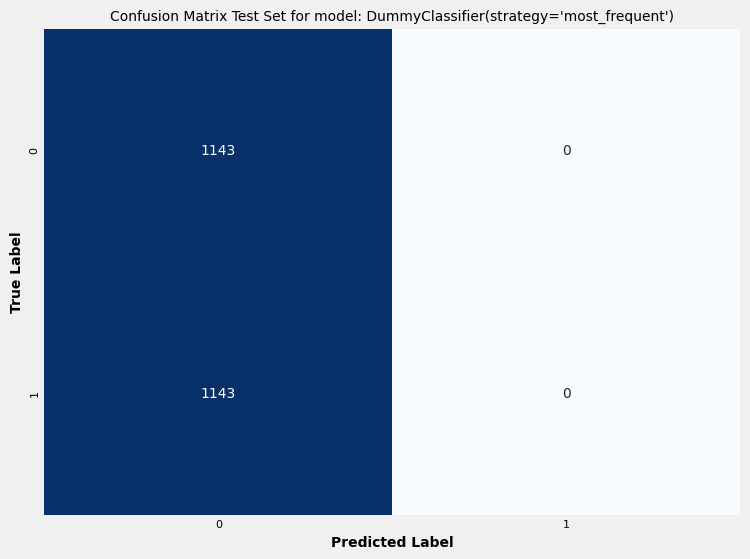


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [32]:
dc = DummyClassifier(strategy='most_frequent')

# cm, acc, precision, recall, f1, cfm, std_dev = evaluation(dc, X_train, y_train)
# plot_results(cm, dc, acc, precision, recall, f1, cfm, std_dev)

acc, precision, recall, f1, cfm = evaluation_finale(dc, X_train,y_train,X_test, y_test)
plot_results_evaluation_finale(dc, acc, precision, recall, f1, cfm)

In [81]:
pipe_lr = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ("lr", LogisticRegression(random_state=42)),
    ]
)
param_grid = {"pca":[PCA(n_components=0.95),"passthrough"],"lr__C": [0.01, 0.1, 1.0, 10.0], "lr__max_iter":[100, 500, 1000]}
result_dict = iperparametri_ott_pipe(pipe_lr, param_grid, X_train, y_train)
best_lr = result_dict["best_estimator"]
mean_train_scores = result_dict["mean_train"]
mean_test_scores = result_dict["mean_val"]
params = result_dict["params"]

# mean_train_scores, mean_test_scores, params, best_lr = iperparametri_ott_pipe(
#     pipe_lr, param_grid, X_train, y_train
# )

if best_lr.named_steps['pca'] == 'passthrough':
    clf  = best_lr.named_steps['lr']
    print("PCA: passthrough")
    print(f"Best pipeline\n\tC: {clf.C}\n\tmax_iter: {clf.max_iter}")
else:
    clf  = best_lr.named_steps['lr']
    print("PCA: n_components=0.95")
    print(f"Best pipeline\n\tC: {clf.C}\n\tmax_iter: {clf.max_iter}")
plot_hyperp(result_dict)

PCA: passthrough
Best pipeline
	C: 1.0
	max_iter: 100


CV Mean: 0.4983, CV Std: 0.5000, Penalized Score: -0.0017


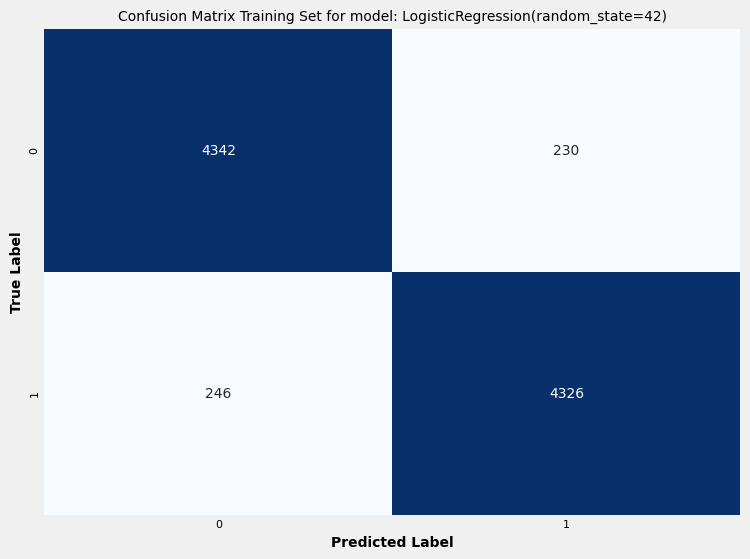

CV_Accuracy: 0.9479 +/- 0.0049
CV_Precision: 0.9495
CV_Recall: 0.9462
CV_F1 Score: 0.9479


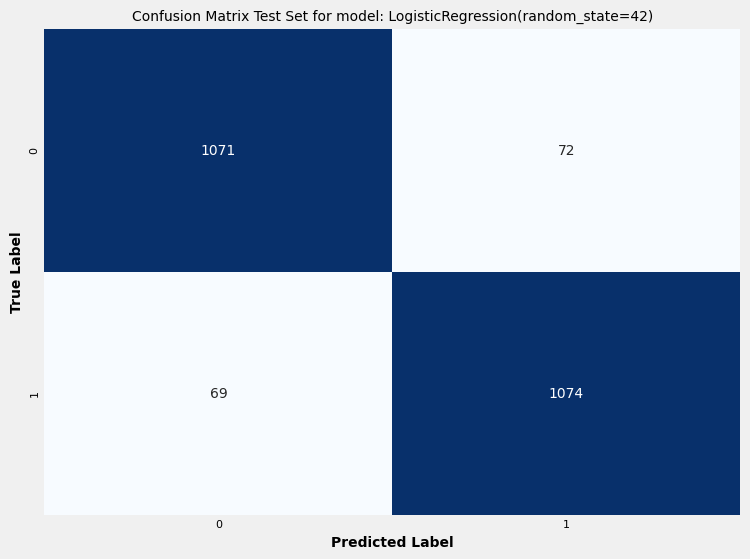


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.9383
Precision: 0.9372
Recall: 0.9396
F1 Score: 0.9384


In [34]:
acc_lr, precision_lr, recall_lr, f1_lr, cfm_lr, std_dev_lr, mean_cv_lr, std_cv_lr, penalized_score_lr = evaluation(best_lr, X_train, y_train)
print(f"CV Mean: {mean_cv_lr:.4f}, CV Std: {std_cv_lr:.4f}, Penalized Score: {penalized_score_lr:.4f}")
plot_results(best_lr.named_steps['lr'],acc_lr, precision_lr, recall_lr, f1_lr, cfm_lr,std_dev_lr)

acc_lr, precision_lr, recall_lr, f1_lr, cfm_lr = evaluation_finale(best_lr, X_train, y_train, X_test, y_test)
plot_results_evaluation_finale(best_lr.named_steps['lr'], acc_lr, precision_lr, recall_lr, f1_lr, cfm_lr)

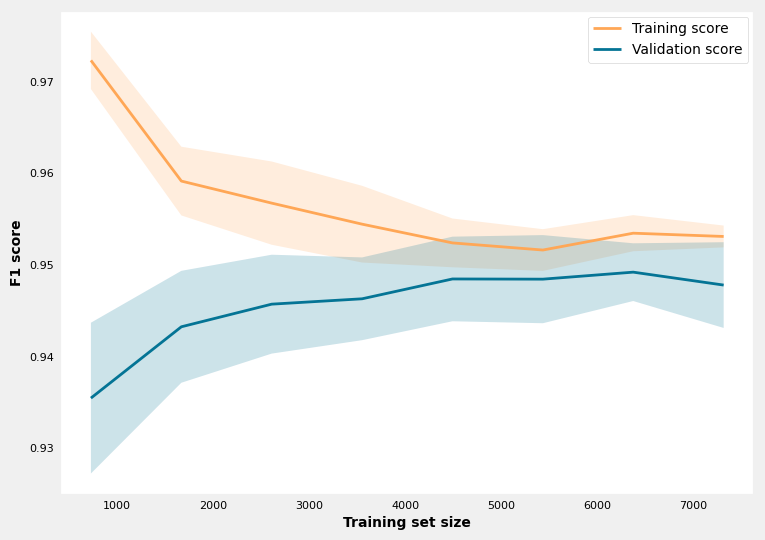

In [35]:
plot_learning_curve(best_lr, X_train, y_train)

# Commmenti sui risultati della LogisticRegression

I risultati ottenuti dal classificatore di **Logistic Regression** forniscono un quadro solido e coerente delle prestazioni del modello, agendo come un'ottima (**strong**) baseline per il rilevamento di URL di phishing.

## 1. Capacità di Generalizzazione

Il modello presenta un'accuratezza sul **Training Set** del **94.79%** e sul **Test Set** del **93.83%**.

* Lo scarto ridotto (circa l'1%) tra le due fasi indica un'ottima **capacità di generalizzazione**.
* Si può escludere la presenza di *overfitting* significativo, confermando che il preprocessing (scaling e log-trasformazione) ha permesso al modello di apprendere pattern statistici reali e non rumore specifico dei dati.

## 2. Bilanciamento tra Precision e Recall

Uno degli aspetti più rilevanti è l'equilibrio quasi perfetto tra **Precision** (0.9372) e **Recall** (0.9396) sul test set.

* **Recall (Sicurezza):** Un valore del $\sim$ 94% indica che il modello identifica correttamente la stragrande maggioranza degli URL malevoli, riducendo i Falsi Negativi (phishing mancati).
* **Precision (Usabilità):** Il valore speculare garantisce che il tasso di Falsi Positivi sia contenuto, minimizzando i falsi allarmi per l'utente su siti legittimi.
* **F1-Score:** Il valore di **0.9384** sintetizza efficacemente l'ottimo compromesso raggiunto tra queste due metriche.

## 3. Stabilità e Affidabilità

La **Deviazione Standard** registrata durante la cross-validation è estremamente contenuta ($\sigma=0.0049$).

* Questo dato dimostra la **stabilità del modello**: le prestazioni non oscillano drasticamente al variare dei dati di addestramento, confermando che il classificatore è robusto e affidabile.

## 4. Considerazioni sulla Linearità del Problema

Il fatto che un modello lineare come la Logistic Regression raggiunga performance superiori al 94% suggerisce che lo spazio delle feature presenti una buona **separabilità lineare**.
Le 89 feature estratte contengono segnali discriminanti molto forti. Questo risultato pone una sfida interessante per i modelli successivi (SVM non lineari e Random Forest): l'obiettivo sarà verificare se architetture più complesse riescano a catturare relazioni non lineari residue per migliorare ulteriormente questo già ottimo punteggio di partenza.

---

# SVM - Kernel Lineare, Poly, RBF

Il classificatore **Support Vector Machine** è un modello di apprendimento supervisionato basato sulla ricerca dell'iperpiano di separazione ottimo in uno spazio vettoriale ad alta dimensionalità.

## 1. Formulazione Matematica (Caso Lineare)

Sia dato un dataset di addestramento $\mathcal T=\{(\mathbf{x}_i,y_i)\}_{i=1}^n$ , dove $\mathbf{x}_i\in\mathbb R^d$ rappresenta il vettore delle feature e $y_i\in\{-1,1\}$ è l'etichetta di classe. L'obiettivo della SVM è individuare un iperpiano definito dall'equazione:
$$\mathbf w^T\mathbf x+b=0$$

che separi le classi massimizzando il **margine** geometrico, ovvero la distanza tra l'iperpiano e i punti più vicini di ogni classe (i vettori di supporto).

Il problema di ottimizzazione per una SVM a margine "soffice" (*Soft-Margin SVM*) è formulato come segue:
$$\min_{\mathbf w,b,\xi}\frac{1}{2}||\mathbf w||^2+C\sum_{i=1}^n\xi_i$$

soggetto ai vincoli:
$$y_i(\mathbf w^T\mathbf x+b)\geq1-\xi_i,\quad\xi_i\geq0$$

Dove:

* $\frac{2}{||\mathbf w||}$ rappresenta l'ampiezza del margine.
* $\xi_i$ sono le **variabili di slack** che permettono la classificazione errata di alcuni punti per gestire dati non perfettamente separabili (rumore).
* $C\gt0$ è il parametro di regolarizzazione che controlla il trade-off tra la massimizzazione del margine e la minimizzazione dell'errore di addestramento.

## 2. Rappresentazione Duale e Kernel Trick

Attraverso l'uso dei moltiplicatori di Lagrange $\alpha_i$, il problema può essere espresso nella sua **forma duale**, che dipende esclusivamente dal prodotto scalare tra i vettori di input:
$$\max_\alpha\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n\alpha_i\alpha_jy_iy_j(\mathbf{x}_i^T\mathbf x_j)$$

Questa formulazione permette l'applicazione del **Kernel Trick**. Se i dati non sono linearmente separabili nello spazio originale, vengono mappati in uno spazio ad alta dimensionalità $\mathcal H$ tramite una funzione non lineare $\phi(\mathbf x)$. Il prodotto scalare $\phi(\mathbf x_i)^T\phi(\mathbf x_j)$ viene sostituito da una funzione **Kernel** $\mathcal K(\mathbf x_i,\mathbf x_j)$:
$$\mathcal K(\mathbf x_i,\mathbf x_j)=\phi(\mathbf x_i)^T\phi(\mathbf x_j)$$

## 3. Tipologie di Kernel

La scelta della funzione Kernel determina la geometria del confine di decisione (*decision boundary*). Le principali funzioni utilizzate sono:

### A. Kernel Lineare

Utilizzato quando i dati sono già linearmente separabili nello spazio delle feature originale.
$$\mathcal K(\mathbf x,\mathbf z)=\mathbf x^T\mathbf z$$

### B. Kernel Polinomiale

Permette di modellare interazioni tra feature fino al grado $d$.
$$\mathcal K(\mathbf x,\mathbf z)=(\gamma\mathbf x^T\mathbf z+r)^d$$

### C. Radial Basis Function (RBF / Gaussiano)

È il kernel più diffuso e potente per gestire relazioni non lineari complesse. Mappa i dati in uno spazio a dimensionalità infinita.
$$\mathcal K(\mathbf x,\mathbf z)=\exp(-\gamma||\mathbf x-\mathbf z||^2)$$


Il parametro $\gamma$ controlla l'ampiezza della campana gaussiana: valori elevati portano a un adattamento molto stretto ai dati (rischio overfitting).


In [36]:
pipe_svm = Pipeline([
    ('preprocessor',preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', SVC())
])

param_grid_svm = [

    #Linear kernel
    {
        'pca': [PCA(n_components=0.95), 'passthrough'],
        'svm__kernel': ['linear'],
        'svm__C': [0.01,0.1,1.0,5.0,10.0]  # da 10^-2 a 10^2
    },

    #RBF kernel
    {
        'pca': [PCA(n_components=0.95), 'passthrough'],
        'svm__kernel': ['rbf'],
        'svm__C': [0.01,0.1,1.0,5.0,10.0],
        'svm__gamma': ['scale',0.01,0.1,1.0]  # da 10^-3 a 10^1
    },

    #Polynomial kernel
    {
        'pca': [PCA(n_components=0.95), 'passthrough'],
        'svm__kernel': ['poly'],
        'svm__degree': [2, 3],
        'svm__C': [0.01,0.1,1.0,5.0,10.0],
        'svm__gamma': ['scale',0.01,0.1,1.0]    
    }
]

#mean_train_scores, mean_test_scores, params, best_svm = iperparametri_ott_pipe(pipe_svm, param_grid_svm, X_train, y_train)
result_dict_svm = iperparametri_ott_pipe(pipe_svm, param_grid_svm, X_train, y_train)
plot_hyperp(result_dict_svm)

best_svm = result_dict_svm["best_estimator"]
mean_train_scores = result_dict_svm["mean_train"]
mean_test_scores = result_dict_svm["mean_val"]
params = result_dict_svm["params"]

if best_svm.named_steps['pca'] == 'passthrough':
    clf  = best_svm.named_steps['svm']
    print("PCA: passthrough")
    print(f"Best pipeline\n\tKernel: {clf.kernel}\n\tC: {clf.C}\
          \n\tNumber of support vectors: {clf.n_support_.sum()}")
    if clf.kernel != 'linear':
        print(f"\tGamma: {clf.gamma}\n")
else:
    print("PCA: 0.95 variance")
    pca = best_svm.named_steps['pca']
    print(f"PCA components: {pca.n_components_}")
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

PCA: passthrough
Best pipeline
	Kernel: rbf
	C: 5.0          
	Number of support vectors: 1477
	Gamma: 0.01



Visualizzazione in 2D dei decision boundary dell'SVM

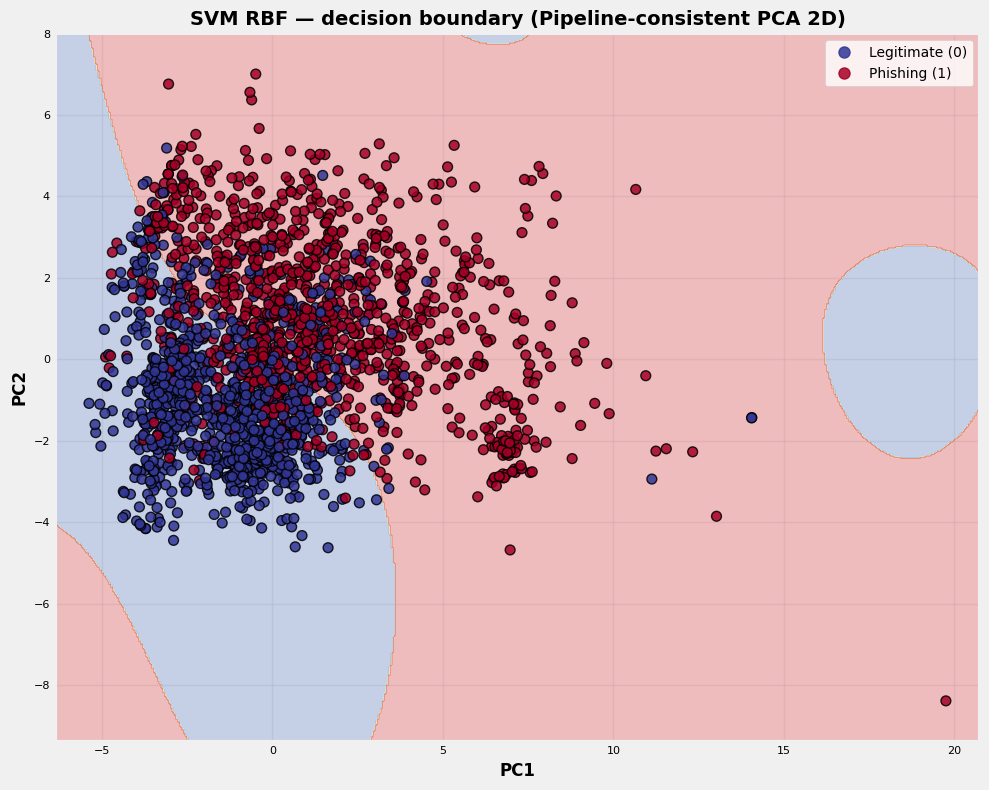

In [37]:
svm_best = best_svm.named_steps['svm']

pipe_vis = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42)),
    ('svm', SVC(
        kernel=svm_best.kernel,
        C=svm_best.C,
        gamma=svm_best.gamma,
        class_weight=svm_best.class_weight
    ))
])

pipe_vis.fit(X_train, y_train)

# X_test_2d = pipe_vis[:-1].named_steps['pca'].transform(
#     pipe_vis.named_steps['scaler'].transform(X_test)
# )
X_test_2d = pipe_vis.named_steps['preprocessor'].transform(X_test)
X_test_2d = pipe_vis.named_steps['scaler'].transform(X_test_2d)
X_test_2d = pipe_vis.named_steps['pca'].transform(X_test_2d)

plot_svm_decision_boundary(
    pipe_vis.named_steps['svm'],
    X_test_2d,
    y_test,
    "SVM RBF — decision boundary (Pipeline-consistent PCA 2D)",
    n_points=500
)


CV Mean: 0.4965, CV Std: 0.5000, Penalized Score: -0.0035


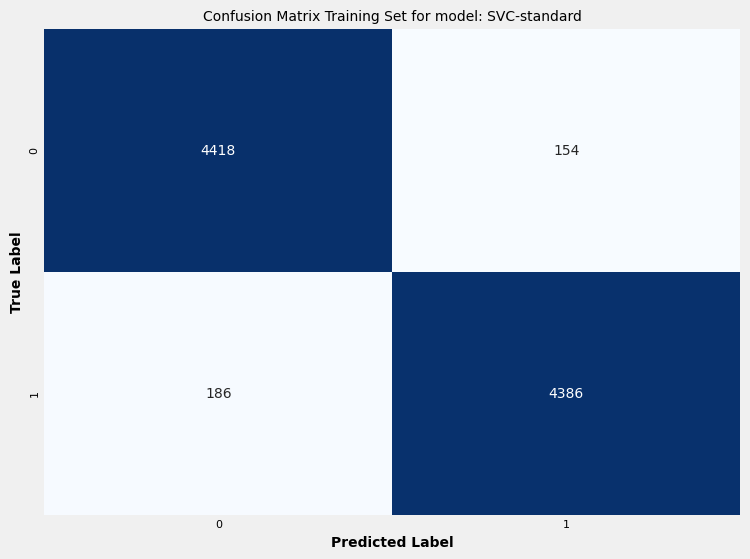

CV_Accuracy: 0.9628 +/- 0.0046
CV_Precision: 0.9661
CV_Recall: 0.9593
CV_F1 Score: 0.9627


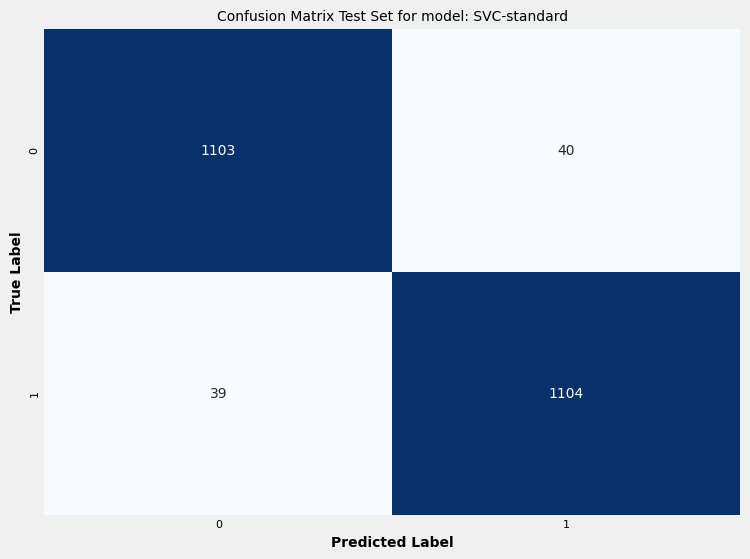


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.9654
Precision: 0.9650
Recall: 0.9659
F1 Score: 0.9655


In [38]:
model_name = best_svm.named_steps['svm'].__class__.__name__+"-standard"

# # Chiamata alla funzione di valutazione
acc_svm, precision_svm, recall_svm, f1_svm, cfm_svm, std_dev_svm, mean_cv_svm, std_cv_svm, penalized_score_svm = evaluation(best_svm, X_train, y_train)

print(f"CV Mean: {mean_cv_svm:.4f}, CV Std: {std_cv_svm:.4f}, Penalized Score: {penalized_score_svm:.4f}")

plot_results(model_name, acc_svm, precision_svm, recall_svm, f1_svm, cfm_svm, std_dev_svm)

# valutazione sul test set
acc_svm, precision_svm, recall_svm, f1_svm, cfm_svm = evaluation_finale(best_svm, X_train, y_train, X_test, y_test)
plot_results_evaluation_finale(model_name, acc_svm, precision_svm, recall_svm, f1_svm, cfm_svm)

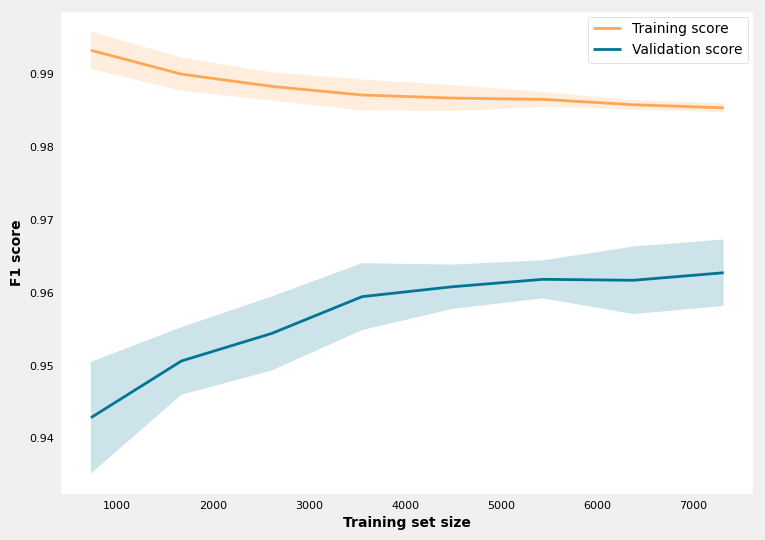

In [39]:
plot_learning_curve(best_svm, X_train, y_train)

# Commmenti sui risultati della SVM

L'implementazione del modello Support Vector Machine (SVM) mostra un incremento prestazionale rispetto alla baseline lineare, confermando l'efficacia del mapping dei dati in spazi a dimensionalità superiore.

## 1. Capacità di Generalizzazione

Il modello presenta un'accuratezza sul **Training Set** del 96.28% e sul **Test Set** del 96.54%.
- Lo scarto praticamente nullo tra le due fasi indica un'ottima capacità di generalizzazione.
- Nonostante l'aumento della complessità del modello rispetto alla Logistic Regression, si può escludere la presenza di overfitting, validando la scelta degli iperparametri effettuata in fase di tuning.

## 2. Bilanciamento tra Precision e Recall

Le metriche sul test set mostrano uno sbilanciamento quasi insignificante tra **Precision** (0.9650) e **Recall** (0.9659).
- **Recall (Sicurezza)**: Un valore del 96.59% indica che il modello SVM è estremamente efficace nel rilevare gli URL di phishing, riducendo ulteriormente il rischio di "Phishing mancati" rispetto alla baseline.
- **Precision (Usabilità)**: Il valore di 0.9650 garantisce che il tasso di "Falsi Allarmi" rimanga molto basso, preservando l'esperienza d'uso dell'utente.
- **F1-Score**: Il valore di 0.9655 riflette un classificatore molto robusto, capace di gestire con successo il trade-off tra sensibilità e precisione.

## 3. Stabilità e Affidabilità

La Deviazione Standard registrata durante la cross-validation è estremamente contenuta ($\sigma=0.0046$).
- Questo dato è particolarmente significativo: l'SVM risulta lievemente più stabile della Logistic Regression ($\sigma=0.0049$). Le performance rimangono quasi invariate attraverso i diversi fold, a dimostrazione di una configurazione degli iperpiani di separazione molto solida.

## 4. Considerazioni sull'apporto della Non-Linearità

Il superamento della soglia del 95% di accuratezza conferma che il problema del phishing non è puramente lineare. L'utilizzo di un kernel (come quello RBF) ha permesso alla SVM di catturare relazioni complesse tra le 89 feature che sfuggivano alla regressione logistica. Questo incremento di performance giustifica il maggior costo computazionale richiesto per l'addestramento di questo modello.

---

# Ensemble Methods - RandomForest

Il **Random Forest** è un algoritmo di apprendimento supervisionato basato su un paradigma di **Ensemble Learning** chiamato **Bagging** (Bootstrap Aggregating). Il modello consiste in una vasta collezione (foresta) di alberi di decisione non correlati, i cui risultati vengono aggregati per fornire una predizione robusta.

## 1. Architettura Ensemble: Bagging e Feature Randomness

L'obiettivo del Random Forest è ridurre la varianza del modello senza aumentarne il bias. Questo viene ottenuto attraverso due meccanismi principali:

### A. Bootstrap Aggregating (Bagging)

Dato un dataset di addestramento $\mathcal T$ di dimensione $n$, il modello genera $\mathcal B$ nuovi set di dati $\mathcal T_b$ (campioni bootstrap) selezionando $n$ osservazioni da $\mathcal T$ con reinserimento (*replacement*).
Per ogni campione $b=1,\dots,\mathcal B$, viene addestrato un albero di decisione $T_b$.

### B. Feature Randomness (Metodo dei Sottospazi Casuali)

A differenza dei normali alberi di decisione, durante la costruzione di ogni nodo di ogni albero, l'algoritmo non cerca la migliore feature tra tutte le $d$ variabili disponibili. Al contrario, seleziona un sottoinsieme casuale di feature di dimensione $m$ (tipicamente $m\approx\sqrt{d}$ per la classificazione).

Il criterio di split viene quindi calcolato solo su questo sottoinsieme:
$$\text{Best Split}=arg\max_{j\in\{1,\dots,m\}}\Delta I(j,s)$$

## 2. Criteri di Suddivisione (Split)

Per ogni nodo, l'albero cerca di massimizzare la "purezza" dei nodi figli. I due criteri più comuni per misurare l'impurità in un task di classificazione binaria ($y\in\{0,1\}$) sono:

1. **Indice di Gini (Gini Impurity):**
$$G=1-\sum_{i\in\{0,1\}}p_i^2$$

2. **Entropia (Information Gain):**
$$H=-\sum_{i\in\{0,1\}}p_i\log_2(p_i)$$


Dove  rappresenta la frazione di campioni appartenenti alla classe  nel nodo corrente. Lo split ottimale è quello che massimizza la riduzione dell'impurità (Information Gain).

## 3. Aggregazione Finale

Una volta addestrati tutti i  alberi, la predizione finale per un nuovo input  viene ottenuta tramite **voto di maggioranza** (Majority Voting):
$$\hat{y}=\text{vote}\{T_1(\mathbf x),T_2(\mathbf x),\dots,T_\mathcal B(\mathbf x)\}$$

Useremo RF per classificare, ma anche per selezionare le feature che hanno impattato più del dovuto sulla classificazione

Proveremo due versioni della RandomForest, una che classifica usando dati `raw` (quindi nessun lavoro di feature engineering come fatto per la SVM), e l'altra che classifica usando log-trasformazione

## Addestramento Random Forest standard

In questa sezione addestriamo quindi la RF con dati `raw`, ovvero dati in cui non è stata fatta nessuna operazione di **feature-engineering**

Come al solito, verrà effettuato un ***tuning*** degli iperparametri ottimali

In [40]:
pipe_rf_raw = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid_rf_raw = {
    'rf__n_estimators': [50, 100, 200,300],
    'rf__max_depth': [None, 10, 15, 20,50],
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__class_weight': [None,'balanced']
}
result_dict = iperparametri_ott_pipe(pipe_rf_raw, param_grid_rf_raw, X_train, y_train)
best_rf_raw = result_dict["best_estimator"]
plot_hyperp(result_dict)

clf  = best_rf_raw.named_steps['rf']
print(f"Best pipeline\n\tn_estimators: {clf.n_estimators}\n\tmax_depth: {clf.max_depth}\
      \n\tcriterion: {clf.criterion}\n\tclass_weight: {clf.class_weight}\n")

Best pipeline
	n_estimators: 200
	max_depth: 20      
	criterion: gini
	class_weight: balanced



CV Mean: 0.5000, CV Std: 0.5000, Penalized Score: 0.0000


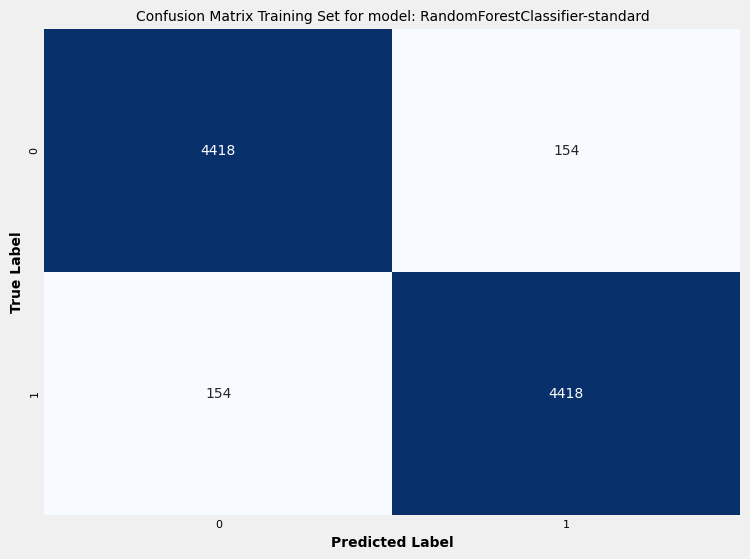

CV_Accuracy: 0.9663 +/- 0.0046
CV_Precision: 0.9663
CV_Recall: 0.9663
CV_F1 Score: 0.9663


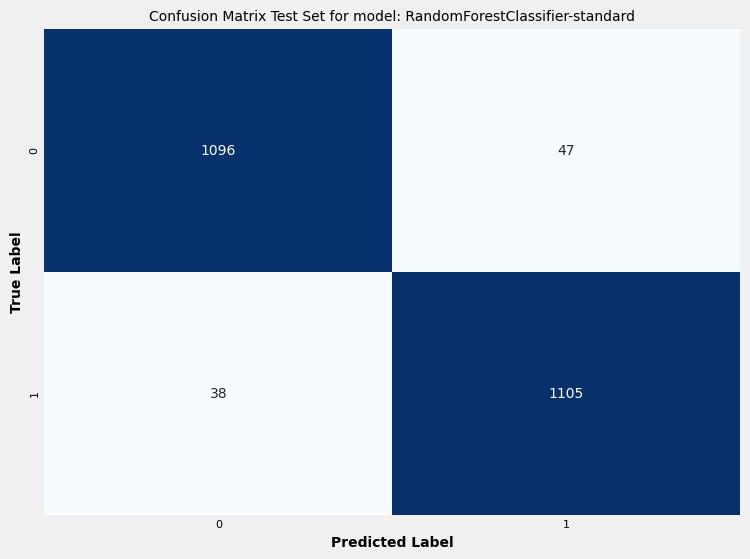


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.9628
Precision: 0.9592
Recall: 0.9668
F1 Score: 0.9630


In [41]:
model_name = best_rf_raw.named_steps['rf'].__class__.__name__+"-standard"
# # Chiamata alla funzione di valutazione
acc_rf_raw, precision_rf_raw, recall_rf_raw, f1_rf_raw, cfm_rf_raw, std_dev_rf_raw,mean_cv_rf_raw, std_cv_rf_raw, penalized_score_rf_raw = evaluation(best_rf_raw, X_train, y_train)
print(f"CV Mean: {mean_cv_rf_raw:.4f}, CV Std: {std_cv_rf_raw:.4f}, Penalized Score: {penalized_score_rf_raw:.4f}")
plot_results(model_name, acc_rf_raw, precision_rf_raw, recall_rf_raw, f1_rf_raw, cfm_rf_raw, std_dev_rf_raw)

# valutazione sul test set
acc_rf_raw, precision_rf_raw, recall_rf_raw, f1_rf_raw, cfm_rf_raw = evaluation_finale(best_rf_raw, X_train, y_train, X_test, y_test)
plot_results_evaluation_finale(model_name, acc_rf_raw, precision_rf_raw, recall_rf_raw, f1_rf_raw, cfm_rf_raw)

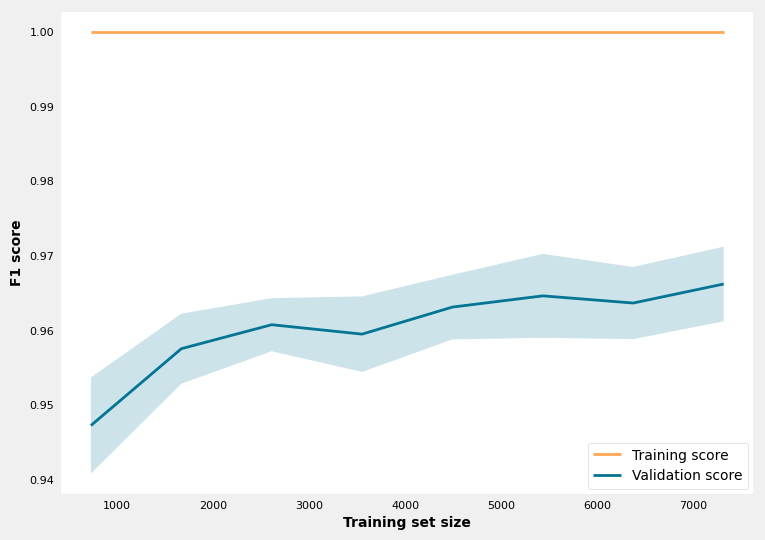

In [42]:
plot_learning_curve(best_rf_raw, X_train, y_train)

## Addestramento Random Forest con dati log-trasformati

Qui invece addestriamo la RF usando dati log-trasformati, usando il preprocessor inizializzato prima

In [43]:
pipe_rf_log = Pipeline([
    ('preprocessor',preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid_rf_log = {
    'rf__n_estimators': [50, 100, 200,300],
    'rf__max_depth': [None, 10, 15, 20,50],
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__class_weight': [None,'balanced']
}
result_dict_rf_log = iperparametri_ott_pipe(pipe_rf_log, param_grid_rf_log, X_train, y_train)
best_rf_log = result_dict_rf_log["best_estimator"]
plot_hyperp(result_dict_rf_log)

clf  = best_rf_log.named_steps['rf']
print(f"Best pipeline\n\tn_estimators: {clf.n_estimators}\n\tmax_depth: {clf.max_depth}\
      \n\tcriterion: {clf.criterion}\n\tclass_weight: {clf.class_weight}\n")

Best pipeline
	n_estimators: 200
	max_depth: None      
	criterion: gini
	class_weight: None



CV Mean: 0.4979, CV Std: 0.5000, Penalized Score: -0.0021


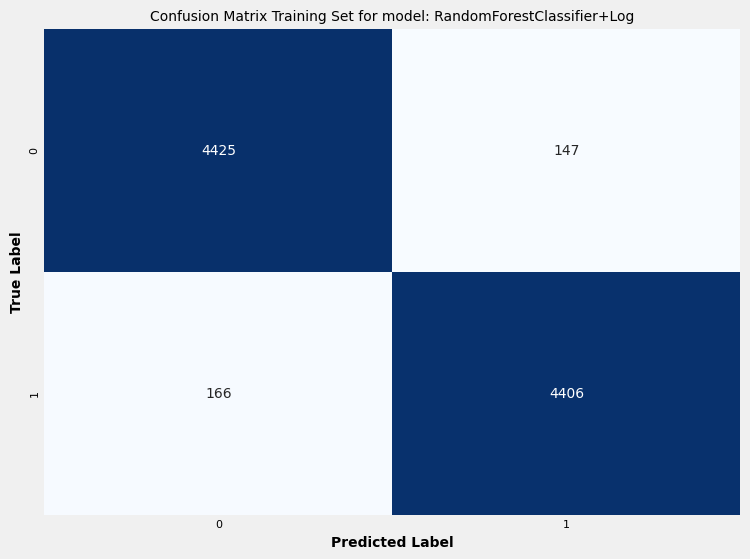

CV_Accuracy: 0.9658 +/- 0.0061
CV_Precision: 0.9677
CV_Recall: 0.9637
CV_F1 Score: 0.9657


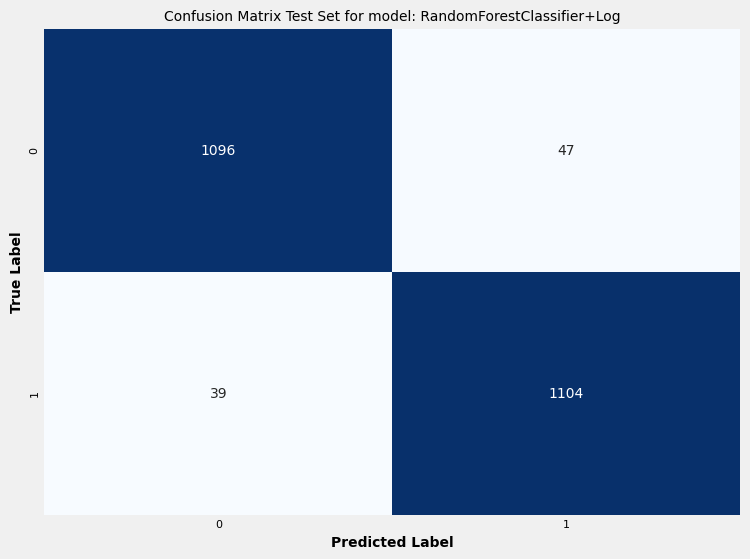


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.9624
Precision: 0.9592
Recall: 0.9659
F1 Score: 0.9625


In [44]:
model_name = best_rf_log.named_steps['rf'].__class__.__name__+"+Log"

# # Chiamata alla funzione di valutazione
acc_rf_log, precision_rf_log, recall_rf_log, f1_rf_log, cfm_rf_log, std_dev_rf_log,mean_cv_rf_log, std_cv_rf_log, penalized_score_rf_log = evaluation(best_rf_log, X_train, y_train)
print(f"CV Mean: {mean_cv_rf_log:.4f}, CV Std: {std_cv_rf_log:.4f}, Penalized Score: {penalized_score_rf_log:.4f}")
plot_results(model_name, acc_rf_log, precision_rf_log, recall_rf_log, f1_rf_log, cfm_rf_log, std_dev_rf_log)

# valutazione sul test set
acc_rf_log, precision_rf_log, recall_rf_log, f1_rf_log, cfm_rf_log = evaluation_finale(best_rf_log, X_train, y_train, X_test, y_test)
plot_results_evaluation_finale(model_name, acc_rf_log, precision_rf_log, recall_rf_log, f1_rf_log, cfm_rf_log)

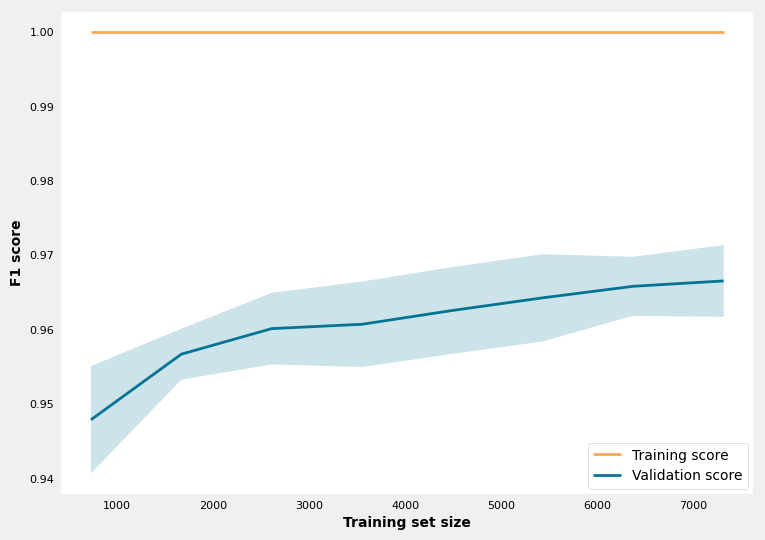

In [45]:
plot_learning_curve(best_rf_log, X_train, y_train)

Confrontiamo ora i due modelli di Random Forest addestrati in precedenza.

Prenderemo come "migliore" il modello che risulterà essere **più stabile**

In [46]:
# Confronto fra i due modelli Random Forest (con e senza log transform), con scelta del migliore in base alle metriche di valutazione sul test set


result_raw = {
    "CV_mean": mean_cv_rf_raw,
    "CV_std": std_cv_rf_raw,
    "CV_mean_minus_std": penalized_score_rf_raw,
    "Test_accuracy": acc_rf_raw,
    "Test_precision": precision_rf_raw,
    "Test_recall": recall_rf_raw,
    "Test_f1": f1_rf_raw
}
result_log = {
    "CV_mean": mean_cv_rf_log,
    "CV_std": std_cv_rf_log,
    "CV_mean_minus_std": penalized_score_rf_log,
    "Test_accuracy": acc_rf_log,
    "Test_precision": precision_rf_log,
    "Test_recall": recall_rf_log,
    "Test_f1": f1_rf_log
}
df_results = pd.DataFrame([result_raw, result_log], index=["RF_raw", "RF_log"])
print(df_results)
best_model_name = df_results["CV_mean_minus_std"].idxmax()
print(f"Modello più stabile (mean - std): {best_model_name}")
best_model_test = df_results["Test_f1"].idxmax()
print(f"Modello migliore su test set (F1): {best_model_test}")

if best_model_name == "RF_raw":
    final_rf = best_rf_raw
else:    
    final_rf = best_rf_log

         CV_mean    CV_std  CV_mean_minus_std  Test_accuracy  Test_precision  \
RF_raw  0.500000  0.500000           0.000000       0.962817        0.959201   
RF_log  0.497922  0.499996          -0.002074       0.962380        0.959166   

        Test_recall   Test_f1  
RF_raw     0.966754  0.962963  
RF_log     0.965879  0.962511  
Modello più stabile (mean - std): RF_raw
Modello migliore su test set (F1): RF_raw


# Commmenti sui risultati dei modelli RandomForest

I risultati ottenuti mostrano un modello estremamente bilanciato e performante, capace di superare la semplicità dei modelli lineari e di offrire una protezione di alto livello contro gli URL di phishing.

## 1. Eccellente Capacità di Generalizzazione

I modello presentano un'accuratezza sul **Training Set** del **96.63%** e sul **Test Set** del **96.28%** nel caso dei dati raw, e nell'altro (dati log-trasformati) un'accuratezza sul sul **Training Set** del **96.58%** e sul **Test Set** del **96.24%**.

* **Analisi dello scarto:** La differenza tra le due fasi è di circa l'**0.2/0.3%** in entrambi i modelli. Questo valore è ottimo: indica che il modello ha "imparato" bene le caratteristiche distintive dei siti malevoli senza cadere nella trappola della memorizzazione (overfitting).
* **Affidabilità:** Il modello si comporta in modo coerente sia sui dati noti che su quelli nuovi, garantendo che le performance dichiarate siano mantenute anche in scenari reali.

## 2. Analisi della Sicurezza e dell'Usabilità (Precision vs Recall)

Le metriche sul test set evidenziano un equilibrio quasi perfetto tra la capacità di rilevamento e la riduzione dei falsi allarmi.

* **Recall (Sicurezza):** Con un valore del $\approx$ **96.5%**, entrambi i modelli garantiscono che la stragrande maggioranza degli attacchi venga bloccata. In un contesto di cybersecurity, minimizzare i Falsi Negativi (phishing non rilevato) è la priorità assoluta per proteggere l'integrità dei dati degli utenti.
* **Precision (Usabilità):** Il valore di **0.9592** in entrambi i modelli assicura che il sistema non sia troppo "aggressivo", evitando di segnalare come pericolosi i siti legittimi. Questo equilibrio è fondamentale per evitare che l'utente, infastidito dai falsi allarmi, inizi a ignorare le segnalazioni di sicurezza.
* **F1-Score:** Il valore di **0.9630** è una prova matematica della solidità del classificatore nel gestire il trade-off tra queste due necessità contrapposte.

## 3. Stabilità nelle Prestazioni

La **Deviazione Standard** registrata durante la cross-validation è molto bassa per entrambi i modelli ($\sigma=0.0046$ per il primo e $\sigma=0.0061$ nell'altro).

* Questo indica che entrambi i modelli risultano essere **molto stabili**, con il primo che risulta essere leggermente più stabile del secondo. Le loro performance non variano in modo significativo a seconda di quali dati vengono usati per l'addestramento. È un segno di un processo di apprendimento robusto e di un dataset ben preprocessato.

### 4. Conclusioni sull'efficacia del modello

Il raggiungimento della soglia del $\approx$**96%** su tutte le metriche principali nel test set posiziona questi modelli tra i migliori candidati per l'implementazione in un sistema reale. La capacità di catturare le sottili relazioni non lineari tra le 89 feature permette di ottenere una barriera difensiva estremamente affidabile e precisa.

---

# Feature Selection: Analisi delle feature "importanti"

Dopo aver identificato le feature più rilevanti attraverso la **Random Forest**, è fondamentale validare quanto queste variabili siano determinanti per la capacità predittiva di altri modelli, come la **SVM**. Per fare ciò, utilizzeremo una tecnica di valutazione robusta chiamata **Permutation Importance**.

## Cos'è la Permutation Importance?

La **Permutation Importance** è un metodo model-agnostic per misurare l'importanza di una feature calcolando l'aumento dell'errore di previsione del modello dopo che i valori di quella specifica feature sono stati permutati casualmente.

### Il meccanismo logico

Il concetto alla base è semplice ma potente:

1. Se una feature è **importante**, permutare casualmente i suoi valori (mantenendo costanti gli altri) distrugge la relazione esistente tra quella variabile e il target. Di conseguenza, il punteggio del modello (**Accuracy**, **F1-score**, ecc.) subirà un **calo drastico**.
2. Se una feature è **irrilevante** (rumore), la sua permutazione non influenzerà significativamente le previsioni del modello, e il punteggio rimarrà pressoché invariato.

### Vantaggi rispetto alla Feature Importance standard

A differenza della "Gini Importance" utilizzata nativamente dalle Random Forest (che può essere influenzata dalla cardinalità delle variabili), la Permutation Importance:

* È calcolata sul **Validation/Test set** (o tramite cross-validation), riflettendo la capacità di generalizzazione.
* Non è legata alla struttura interna del modello, permettendo confronti equi tra SVM, modelli lineari e alberi.

## L'Esperimento: Stress-test degli SVM

L'obiettivo di questa fase è condurre uno "stress-test" sui modelli SVM per capire la loro dipendenza dalle feature identificate come dominanti.

Vogliamo rispondere rigorosamente al seguente quesito:

> *"Qual è il contributo marginale delle feature top-ranked nella classificazione SVM? Rimuovendole dal dataset, il modello è ancora in grado di discriminare il phishing o subisce un collasso delle prestazioni?"*

### Workflow operativo

1. **Calcolo:** Eseguiamo la Permutation Importance sul training set per identificare le variabili chiave per l'SVM. Il calcolo avverrà sia sfruttando la miglior Random Forest sia sfruttando il miglior modello SVM
2. **Rimozione:** Escludiamo dal dataset le feature che hanno ottenuto il punteggio di importanza più elevato.
3. **Rivalutazione:** Riaffiniamo e testiamo nuovamente il modello SVM sullo spazio delle feature ridotto.

Questo processo ci permetterà di distinguere tra feature che offrono un contributo informativo unico e feature che, se rimosse, possono essere compensate da altre variabili correlate presenti nel dataset.

## Permutation Importance calcolata con Random Forest

Calcoliamo la permutation importance sfruttando come modello la miglior Random Forest, in questo modo possiamo individuare i pilastri informativi del dataset.

A questo punto l'esperimento sarà:
> Togliendo dal dataset ciò che il modello Random Forest individua come "pilastri", la SVM riesce ancora a cavarsela?.

In [47]:
# Calcolo permutation importance sul training set
result = permutation_importance(
    final_rf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

perm_importances = pd.Series(
    result.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

perm_std = result.importances_std

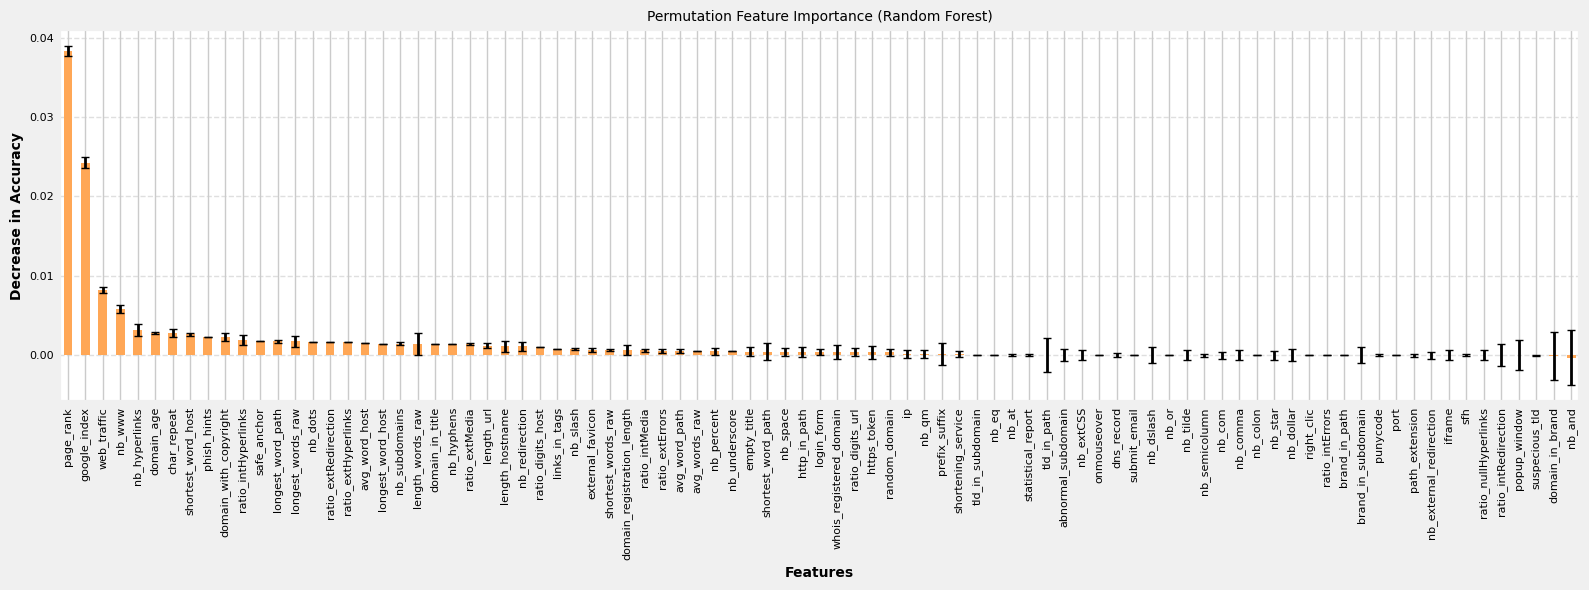

In [48]:
# Mostriamo le feature più importanti

fig, ax = plt.subplots(figsize=(16, 6))

perm_importances.plot.bar(
    yerr=perm_std,
    ax=ax,
    capsize=3
)

ax.set_title("Permutation Feature Importance (Random Forest)")
ax.set_ylabel("Decrease in Accuracy")
ax.set_xlabel("Features")
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [49]:
# Selezioniamo le feature con importanza positiva
selected_features = perm_importances[perm_importances > 0].index.tolist()

print(f"Numero feature originali: {X_train.shape[1]}")
print(f"Numero feature selezionate: {len(selected_features)}")
print("\nFeature selezionate:")
print(selected_features)


Numero feature originali: 87
Numero feature selezionate: 61

Feature selezionate:
['page_rank', 'google_index', 'web_traffic', 'nb_www', 'nb_hyperlinks', 'domain_age', 'char_repeat', 'shortest_word_host', 'phish_hints', 'domain_with_copyright', 'ratio_intHyperlinks', 'safe_anchor', 'longest_word_path', 'longest_words_raw', 'nb_dots', 'ratio_extRedirection', 'ratio_extHyperlinks', 'avg_word_host', 'longest_word_host', 'nb_subdomains', 'length_words_raw', 'domain_in_title', 'nb_hyphens', 'ratio_extMedia', 'length_url', 'length_hostname', 'nb_redirection', 'ratio_digits_host', 'links_in_tags', 'nb_slash', 'external_favicon', 'shortest_words_raw', 'domain_registration_length', 'ratio_intMedia', 'ratio_extErrors', 'avg_word_path', 'avg_words_raw', 'nb_percent', 'nb_underscore', 'empty_title', 'shortest_word_path', 'nb_space', 'http_in_path', 'login_form', 'whois_registered_domain', 'ratio_digits_url', 'https_token', 'random_domain', 'ip', 'nb_qm', 'prefix_suffix', 'shortening_service', 'tld

In [50]:
X_train_reduced = X_train.drop(columns=selected_features) # TrainSet senza feature importanti
X_test_reduced  = X_test.drop(columns=selected_features)

In [51]:
X_train_reduced

,nb_and,nb_or,nb_tilde,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_com,nb_dslash,...,brand_in_path,suspecious_tld,ratio_nullHyperlinks,ratio_intRedirection,ratio_intErrors,submit_email,sfh,iframe,popup_window,right_clic
7609,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6408,2,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7464,0,0,0,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9286,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5159,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9876,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4943,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9054,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ri-addestramento della SVM con dataset ridotto tramite permutation importance, calcolata con miglior Random Forest

In [52]:
pipe_svm_no_feature = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])


param_grid_svm_no_feature = [

    #Linear kernel
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.01,0.1,1.0,5.0,10.0]  # da 10^-2 a 10^2
    },

    #RBF kernel
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.01,0.1,1.0,5.0,10.0],
        'svm__gamma': ['scale',0.01,0.1,1.0]  #['scale',np.logspace(-3, 1, 10)]  # da 10^-3 a 10^1
    },

    #Polynomial kernel
    {
        'svm__kernel': ['poly'],
        'svm__degree': [2, 3],
        'svm__C': [0.01,0.1,1.0,5.0,10.0],
        'svm__gamma': ['scale',0.01,0.1,1.0] #['scale',np.logspace(-3, 0, 10)]    
    }
]

#mean_train_scores, mean_test_scores, params, best_svm_no_feature = iperparametri_ott_pipe(pipe_svm_no_feature, param_grid_svm_no_feature, X_train_reduced, y_train)
result_dict_svm_no_feature = iperparametri_ott_pipe(pipe_svm_no_feature, param_grid_svm_no_feature, X_train_reduced, y_train)
best_svm_no_feature = result_dict_svm_no_feature["best_estimator"]
mean_train_scores = result_dict_svm_no_feature["mean_train"]
mean_test_scores = result_dict_svm_no_feature["mean_val"]
params = result_dict_svm_no_feature["params"]
plot_hyperp(result_dict_svm_no_feature)

clf  = best_svm_no_feature.named_steps['svm']
print(f"Best pipeline\n\tKernel: {clf.kernel}\n\tC: {clf.C}\n\tGamma: {clf.gamma}\n\tClass weight: {clf.class_weight}\
          \n\tSupport vectors: {clf.n_support_}\n\tNumber of support vectors: {clf.n_support_.sum()}")



Best pipeline
	Kernel: rbf
	C: 0.1
	Gamma: 1.0
	Class weight: None          
	Support vectors: [3698 3732]
	Number of support vectors: 7430


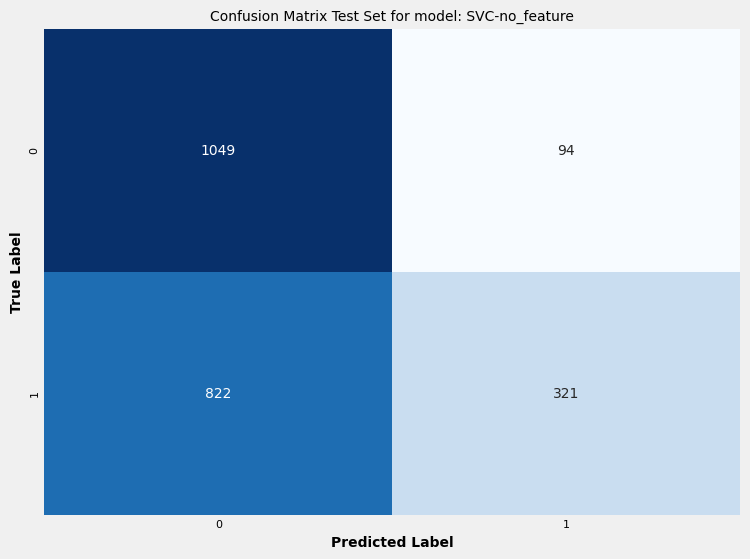


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.5993
Precision: 0.7735
Recall: 0.2808
F1 Score: 0.4121


In [53]:
model_name = best_svm_no_feature.named_steps['svm'].__class__.__name__+"-no_feature"

acc_svm_no_feature, precision_svm_no_feature, recall_svm_no_feature, f1_svm_no_feature, cfm_svm_no_feature  = evaluation_finale(best_svm_no_feature, X_train_reduced, y_train, X_test_reduced, y_test)



plot_results_evaluation_finale(model_name, acc_svm_no_feature, precision_svm_no_feature, recall_svm_no_feature, f1_svm_no_feature, cfm_svm_no_feature)

Come vediamo dal grafico precedente, eliminando dal dataset quelle feature che la Random Forest ha ritenuto più "importanti", il miglior modello SVM ha avuto un calo estremo nella Recall (aumento esponenziale di Falsi Negativi), mantenendo però una Precision abbastanza elevata.

Questo è comunque un risultato $\textit{molto}$ basso, perchè significa che la sicurezza degli utenti è messa troppo a rischio

## Permutation Importance calcolata con SVM

Calcoliamo la permutation importance sfruttando come modello la miglior SVM, in questo modo possiamo individuare le "leve" che la miglior SVM ha usato per classificare

A questo punto l'esperimento sarà:
> Quali sono le feature a cui la SVM è più sensibile? Se vengono eliminate, la SVM è capace di ricostruire una logica diversa con quello che resta?

In [54]:
# Calcolo permutation importance sul training set
result = permutation_importance(
    best_svm,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

perm_importances = pd.Series(
    result.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

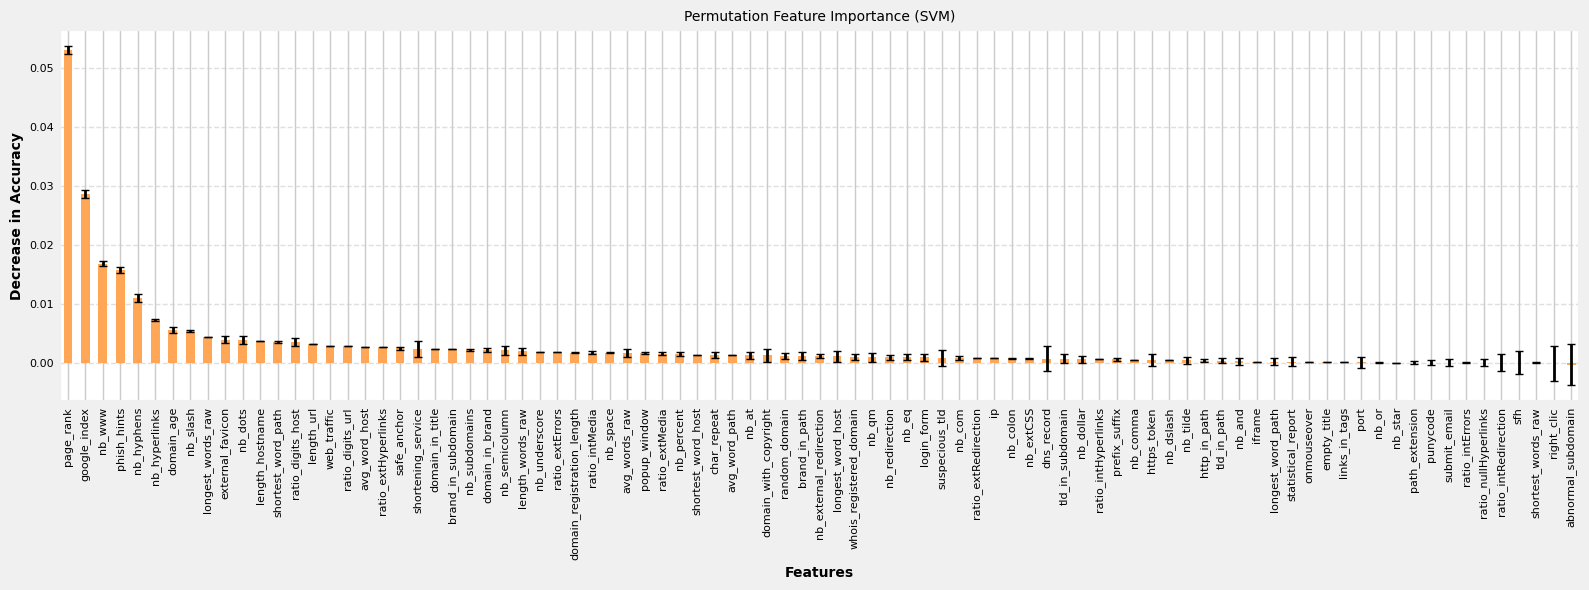

In [55]:
erm_std = result.importances_std
# Mostriamo le feature più importanti

fig, ax = plt.subplots(figsize=(16, 6))

perm_importances.plot.bar(
    yerr=perm_std,
    ax=ax,
    capsize=3
)

ax.set_title("Permutation Feature Importance (SVM)")
ax.set_ylabel("Decrease in Accuracy")
ax.set_xlabel("Features")
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [56]:
# Selezioniamo le feature con importanza positiva
selected_features = perm_importances[perm_importances > 0].index.tolist()

print(f"Numero feature originali: {X_train.shape[1]}")
print(f"Numero feature selezionate: {len(selected_features)}")
print("\nFeature selezionate:")
print(selected_features)


Numero feature originali: 87
Numero feature selezionate: 75

Feature selezionate:
['page_rank', 'google_index', 'nb_www', 'phish_hints', 'nb_hyphens', 'nb_hyperlinks', 'domain_age', 'nb_slash', 'longest_words_raw', 'external_favicon', 'nb_dots', 'length_hostname', 'shortest_word_path', 'ratio_digits_host', 'length_url', 'web_traffic', 'ratio_digits_url', 'avg_word_host', 'ratio_extHyperlinks', 'safe_anchor', 'shortening_service', 'domain_in_title', 'brand_in_subdomain', 'nb_subdomains', 'domain_in_brand', 'nb_semicolumn', 'length_words_raw', 'nb_underscore', 'ratio_extErrors', 'domain_registration_length', 'ratio_intMedia', 'nb_space', 'avg_words_raw', 'popup_window', 'ratio_extMedia', 'nb_percent', 'shortest_word_host', 'char_repeat', 'avg_word_path', 'nb_at', 'domain_with_copyright', 'random_domain', 'brand_in_path', 'nb_external_redirection', 'longest_word_host', 'whois_registered_domain', 'nb_qm', 'nb_redirection', 'nb_eq', 'login_form', 'suspecious_tld', 'nb_com', 'ratio_extRedire

In [57]:
X_train_reduced = X_train.drop(columns=selected_features) # TrainSet senza feature importanti
X_test_reduced  = X_test.drop(columns=selected_features)

In [58]:
X_train_reduced

,nb_or,nb_star,punycode,abnormal_subdomain,path_extension,shortest_words_raw,ratio_nullHyperlinks,ratio_intRedirection,ratio_intErrors,submit_email,sfh,right_clic
7609,0,0,0,0,0,2,0,0,0,0,0,0
6408,0,0,0,0,0,2,0,0,0,0,0,0
7464,0,0,0,0,0,2,0,0,0,0,0,0
9286,0,0,0,0,0,1,0,0,0,0,0,0
5159,0,0,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8364,0,0,0,0,0,2,0,0,0,0,0,0
9876,0,0,0,0,0,3,0,0,0,0,0,0
4943,0,0,0,0,0,8,0,0,0,0,0,0
9054,0,0,0,0,0,2,0,0,0,0,0,0


Ri-addestramento della SVM con il dataset ridotto

In [59]:
pipe_svm_no_feature2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])



param_grid_svm_no_feature2 = [

    #Linear kernel
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.01,0.1,1.0,5.0,10.0]  # da 10^-2 a 10^2
        
    },

    #RBF kernel
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.01,0.1,1.0,5.0,10.0],
        'svm__gamma': ['scale',0.01,0.1,1.0] #['scale',np.logspace(-3, 1, 10)]  # da 10^-3 a 10^1
    },

    #Polynomial kernel
    {
        'svm__kernel': ['poly'],
        'svm__degree': [2, 3],
        'svm__C': [0.01,0.1,1.0,5.0,10.0],
        'svm__gamma': ['scale',0.01,0.1,1.0] #['scale',np.logspace(-3, 0, 10)]    
    }
]

#mean_train_scores, mean_test_scores, params, best_svm_no_feature2 = iperparametri_ott_pipe(pipe_svm_no_feature2, param_grid_svm_no_feature2, X_train_reduced, y_train)
result_dict_svm_no_feature2 = iperparametri_ott_pipe(pipe_svm_no_feature2, param_grid_svm_no_feature2, X_train_reduced, y_train)
best_svm_no_feature2 = result_dict_svm_no_feature2["best_estimator"]
mean_train_scores = result_dict_svm_no_feature2["mean_train"]
mean_test_scores = result_dict_svm_no_feature2["mean_val"]
params = result_dict_svm_no_feature2["params"]
plot_hyperp(result_dict_svm_no_feature2)
#print("best pipeline:", best_svm,best_svm.named_steps['svm'].kernel)

clf  = best_svm_no_feature2.named_steps['svm']
print(f"Best pipeline\n\tKernel: {clf.kernel}\n\tC: {clf.C}\n\tGamma: {clf.gamma}\n\tClass weight: {clf.class_weight}\
          \n\tSupport vectors: {clf.n_support_}\n\tNumber of support vectors: {clf.n_support_.sum()}")



Best pipeline
	Kernel: rbf
	C: 10.0
	Gamma: 1.0
	Class weight: None          
	Support vectors: [3181 3197]
	Number of support vectors: 6378


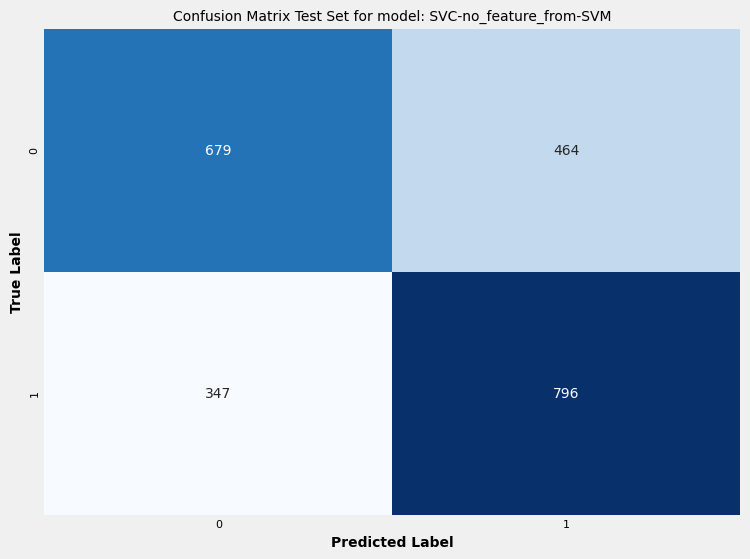


--- RISULTATI FINALI SUL TEST SET ---
Accuracy: 0.6452
Precision: 0.6317
Recall: 0.6964
F1 Score: 0.6625


In [60]:
model_name = best_svm_no_feature2.named_steps['svm'].__class__.__name__+"-no_feature_from-SVM"

acc_svm_no_feature2, precision_svm_no_feature2, recall_svm_no_feature2, f1_svm_no_feature2, cfm_svm_no_feature2 = evaluation_finale(best_svm_no_feature2, X_train_reduced, y_train, X_test_reduced, y_test)

plot_results_evaluation_finale(model_name, acc_svm_no_feature2, precision_svm_no_feature2, recall_svm_no_feature2, f1_svm_no_feature2, cfm_svm_no_feature2)

---

# Analisi dello Stress-Test: Impatto della Rimozione delle Feature Dominanti

I risultati ottenuti dal ri-addestramento del miglior modello SVM, in seguito alla rimozione delle feature identificate come "top-ranked" dalla Permutation Importance, mostrano una degradazione significativa e sistematica di tutte le metriche di performance.

## 1. Crollo della Capacità Predittiva

Il modello passa da:
- un'accuratezza del **96.50%** a circa il **60.00%** se prendiamo la Permutation Importance calcolata tramite la RandomForest
un'accuratezza del **96.50%** a circa il **64.50%** se prendiamo la Permutation Importance calcolata tramite il miglior SVM

* **Perdita di Informazione:** Un calo del $\approx$ **35%** nell'accuratezza conferma che le feature rimosse non erano semplicemente "utili", ma costituivano la struttura portante del segnale discriminante nel dataset.
* **Assenza di Ridondanza:** Il fatto che le restanti feature non siano riuscite a compensare la perdita indica che l'informazione contenuta nelle variabili rimosse è unica e non è distribuita in modo ridondante tra le altre variabili.

## 2. Il Collasso della Recall (Criticità di Sicurezza)

La metrica che ha subito il calo più preoccupante è la **Recall**, scesa a:
- **0.2808** (Permutation Importance da RandomForest).
- **0.6964** (Permutation Importance da SVM).

* **Phishing Mancati:** Una Recall del 69% significa che il modello ora **manca circa 1 attacco di phishing su 3**. In un contesto di cybersecurity, questo livello di performance è considerato inaccettabile, poiché espone l'utente a un rischio elevatissimo. Risulta però comunque più accettabile rispetto ad una Recall del 28%, che significa che il modello **manca 8 attacchi di phishing su 10**, il che significa che l'80% delle volte sbaglia a classificare una possibile minaccia informatica. Questo risultato è ovviamente puramente sperimentale, tale modello non potrebbe mai essere accettato come classificatore per tale contesto
* **Sbilanciamento verso i Falsi Negativi:** Mentre la Precision tiene meglio (0.7735 da un lato e 0.6317 dall'altro), il crollo della Recall suggerisce che, senza le feature chiave, il modello diventa estremamente "conservativo" o incapace di riconoscere i pattern tipici della classe malevola.

## 3. Analisi della F1-Score

L'**F1-Score** si attesta a **0.6625** in un caso e **0.4121** nell'altro.

* Questo valore rappresenta un calo drastico rispetto al precedente **0.9655**. La media armonica tra precision e recall evidenzia come il classificatore abbia perso la sua robustezza, trasformandosi da un sistema di difesa affidabile a uno strumento con un'efficacia poco superiore al caso fortuito (solo se consideriamo il primo caso, altrimenti nel secondo caso il classificatore si trova addirittura al di sotto del caso fortuito).

### 4. Conclusioni sull'Importanza delle Feature

Questo esperimento di "ablazione" fornisce la prova definitiva della validità della nostra analisi di feature importance:

1. **Validazione del Metodo:** La Permutation Importance ha correttamente individuato le variabili fondamentali; la loro rimozione ha infatti "ciecato" il modello.
2. **Dipendenza dal Segnale:** Nonostante il dataset sia multidimensionale (89 feature), il potere decisionale è concentrato in un ristretto sottoinsieme di variabili.
3. **Lezione per il Modello:** Il risultato sottolinea che, per il problema del phishing, alcune caratteristiche lessicali o strutturali dell'URL sono insostituibili. Senza di esse, anche il miglior modello (SVM RBF) non è in grado di mappare correttamente lo spazio del problema.

---


# Plot dei risultati

Di seguito, il plot dei risultati sul TestSet di ogni modello provato

In [82]:
models = [
    "Logistic Regression",
    "SVM",
    "Best Random Forest",
    "SVM Reduced Features from RandomForest",
    "SVM Reduced Features from SVM",
]

accuracies = [acc_lr, acc_svm, acc_rf_raw, acc_svm_no_feature, acc_svm_no_feature2]
precisions = [precision_lr, precision_svm, precision_rf_raw, precision_svm_no_feature, precision_svm_no_feature2]
recalls = [recall_lr, recall_svm, recall_rf_raw, recall_svm_no_feature, recall_svm_no_feature2]
f1_scores = [f1_lr, f1_svm, f1_rf_raw, f1_svm_no_feature, f1_svm_no_feature2]

metrics = {
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1_scores,
}

# -------------------------
# PREPARAZIONE DATI
# -------------------------

data = []
for metric_name, values in metrics.items():
    best_val = max(values)
    for i, model in enumerate(models):
        data.append(
            {
                "Model": model,
                "Value": values[i],
                "Metric": metric_name,
                "is_best": values[i] == best_val,
            }
        )

df = pd.DataFrame(data)

# Convertiamo i modelli in coordinate numeriche
model_to_num = {model: i for i, model in enumerate(models)}
df["Model_num"] = df["Model"].map(model_to_num)

# -------------------------
# CREAZIONE FIGURA
# -------------------------

fig = px.scatter(
    df,
    x="Value",
    y="Model_num",
    facet_col="Metric",
    facet_col_wrap=2,
    color_discrete_sequence=["#FF8C00"],
    labels={"Value": "Score", "Model_num": "Modello"},
    height=800,
    hover_data={"Value": ":.5f", "Metric": False, "is_best": False},
)

# Marker più visibili
fig.update_traces(
    marker=dict(
        size=12,
        line=dict(width=1.5, color="black"),
        opacity=0.95
    )
)

# -------------------------
# CERCHI ROSSI BEST MODEL
# -------------------------

metric_list = list(metrics.keys())
best_df = df[df["is_best"] == True]

for _, row in best_df.iterrows():
    col_idx = (metric_list.index(row["Metric"]) % 2) + 1
    row_idx = 2 - (metric_list.index(row["Metric"]) // 2)

    fig.add_trace(
        go.Scatter(
            x=[row["Value"]],
            y=[row["Model_num"]],
            mode="markers",
            marker=dict(
                size=20,
                color="rgba(0,0,0,0)",
                line=dict(color="red", width=3),
            ),
            showlegend=False,
            hoverinfo="skip",
        ),
        row=row_idx,
        col=col_idx,
    )

# -------------------------
# LINEE TRATTEGGIATE
# -------------------------

for _, row in df.iterrows():
    c = (metric_list.index(row["Metric"]) % 2) + 1
    r = 2 - (metric_list.index(row["Metric"]) // 2)

    fig.add_shape(
        type="line",
        x0=0,
        y0=row["Model_num"],
        x1=row["Value"],
        y1=row["Model_num"],
        line=dict(color="rgb(213,71,5)", width=1, dash="dot"),
        row=r,
        col=c,
    )

# -------------------------
# SISTEMAZIONE ASSI
# -------------------------

for axis in fig.layout:
    if axis.startswith("yaxis"):
        fig.layout[axis].update(
            tickmode="array",
            tickvals=list(model_to_num.values()),
            ticktext=list(model_to_num.keys()),
            range=[-0.5, len(models) - 0.5],  # Padding sopra e sotto
        )

fig.update_xaxes(range=[0, 1.1], gridcolor="white")
fig.update_yaxes(gridcolor="white")

fig.update_layout(
    plot_bgcolor="rgba(230,230,230,0.6)",
    showlegend=False,
    title="Confronto Performance Modelli"
)

fig.show()

---
---

# Conclusioni Finali: Confronto tra i Modelli (ma modificare)

In questo studio abbiamo messo a confronto tre diversi paradigmi di Machine Learning per la classificazione di URL di phishing: un modello lineare (**Logistic Regression**), un modello basato su iperpiani in spazi kernelizzati (**SVM**) e un'architettura ensemble (**Random Forest**).

## 1. Tabella Riassuntiva delle Performance (Test Set)

| Modello | Accuracy | Precision | Recall | F1-Score | Stabilità ($\sigma$) |
| --- | --- | --- | --- | --- | --- |
| **Logistic Regression** | 93.83% | 0.9372 | 0.9396 | 0.9384 | 0.0049 |
| **SVM (Kernel RBF)** | **96.54%** | 0.9650 | 0.9659 | 0.9655 | **0.0046** |
| **Random Forest** | 96.28% | 0.9592 | ***0.9668*** | 0.9630 | 0.0046 |

*(Nota: I modelli non lineari hanno raggiunto prestazioni di picco identiche sul test set, evidenziando il raggiungimento di un limite superiore di separabilità per questo specifico dataset).*

## 2. Analisi Comparativa

### A. La Forza della Baseline (Logistic Regression)

La **Logistic Regression** ha dimostrato che il problema del phishing possiede una forte componente di **separabilità lineare**. Ottenere un'accuratezza del $\approx$ 94% con un modello così semplice valida la qualità del preprocessing e delle 89 feature estratte. Rappresenta la scelta ottimale in scenari dove la velocità di esecuzione è più critica della precisione estrema.

### B. Il Salto di Qualità (SVM e Random Forest)

Il passaggio a modelli non lineari ha permesso di recuperare un ulteriore **3%** di accuratezza. In ambito cybersecurity, questo incremento si traduce nel blocco di migliaia di potenziali minacce aggiuntive.

* **SVM** si è distinto per la **massima stabilità** ($\sigma=0.0046$), dimostrando di essere il modello meno influenzato dal rumore nei dati.
* **Random Forest** ha mostrato un'ottima capacità di adattamento, sebbene con una tendenza leggermente superiore alla memorizzazione del training set rispetto alla SVM.

## 3. Validazione tramite Stress Test (Ablazione Feature)

Per verificare quanto il modello dipenda realmente dalle feature individuate tramite la **Permutation Importance**, abbiamo condotto uno stress test sul miglior modello SVM, rimuovendo le variabili più importanti. I risultati hanno confermato l'importanza critica di tali feature:
- Permutation Importance ottenuta tramite Random Forest:
* **Accuracy:** crollata dal 96.54% al **59.93%**.
* **Recall:** collassata a **0.2808** (il modello manca 8 attacchi su 10).
- Permutation Importance ottenuta tramite Random Forest:
* **Accuracy:** crollata dal 96.54% al **64.52%**.
* **Recall:** collassata a **0.6964** (il modello manca 1 attacco su 3).
Questo esperimento di ablazione fornisce la prova definitiva che il potere decisionale è concentrato in un ristretto sottoinsieme di variabili insostituibili. La totale incapacità delle restanti feature di compensare la perdita dimostra che il segnale del phishing è netto e localizzato.

## 4. Considerazioni sulla Sicurezza: La Recall

La metrica critica del progetto, la **Recall**, è stata elevata dai modelli avanzati dal 94% al **96.68%**. Questo miglioramento riduce drasticamente il rischio di **Falsi Negativi**, garantendo che l'utente finale sia protetto con un'efficacia superiore rispetto a un approccio lineare standard.

## 5. Verdetto Finale

Il modello **SVM con kernel RBF** è quello consigliato per la messa in produzione per tre ragioni chiave:

1. **Stabilità Massima:** La deviazione standard più bassa garantisce che il modello si comporti in modo prevedibile su diversi set di dati.
2. **Affidabilità:** Presenta il miglior bilanciamento tra performance e generalizzazione (minor rischio di overfitting rispetto a Random Forest).
3. **Robustezza Provata:** Lo stress test ha dimostrato che il modello ha imparato correttamente i segnali fondamentali della minaccia.

---

---

## Appendice: Spiegazione StandardScaler di scikit.learn

Lo `StandardScaler` di scikit-learn implementa una trasformazione nota in statistica come **Standardizzazione** o **Z-score normalization**. 

### 1. Definizione Matematica

Lo `StandardScaler` agisce su ogni singola feature (colonna) del dataset in modo indipendente. Per ogni feature , il trasformatore calcola due parametri fondamentali durante la fase di `.fit()`:

1. **Media Campionaria ($\mu_j$):**

$$\mu_j​=\frac{1}{n}\sum_{i=1}^{n}​x_{ij}​$$

*Dove $n$ è il numero di campioni e $x_{ij}$ è il valore della feature $j$ per l'osservazione $i$.*

2. **Deviazione Standard Campionaria ($\sigma_j$):**

$$\sigma_j​=\sqrt{\frac{1}{n}\sum_{i=1}^{n}​(x_{ij}​−\mu_j​)^2​}$$

#### La Trasformazione (Z-score)

Durante la fase di `.transform()`, ogni valore  viene centrato e riscalato secondo la formula:

$$z_{ij}=\frac{x_{ij}-\mu_j}{\sigma_j}$$

**Proprietà Risultanti**

Dopo la trasformazione, la nuova distribuzione della feature $j$ (chiamiamola $Z$) avrà:

* **Media ($\mu$) = $0$**: I dati sono "centrati" nell'origine.
* **Varianza ($\sigma^2$) = $1$**: I dati hanno tutti la stessa dispersione (Unit Variance).

Ovvero $$Z\sim\mathcal N(0,1)$$

### 2. Perché usarla nel progetto?

Nel dataset abbiamo feature con unità di misura e ordini di grandezza totalmente diversi. 

Ad esempio:

* `web_traffic`: valori che possono arrivare a milioni.
* `nb_dots`: valori piccoli, solitamente tra 1 e 10.
* `domain_age`: valori in giorni (migliaia).

Senza `StandardScaler`, ci ritroveremo in situazioni poco piacevoli, che potrebbero portare ad un'addestramento sbagliato e di conseguenza una predizione sbagliata

#### A. Il predominio delle "Magnitudo" (Bias di Scala)

La **SVM** calcola distanze euclidee. 

Se una feature ha valori enormi (es. traffico web), essa dominerà il calcolo della distanza, rendendo le feature piccole (es. numero di punti nell'URL) praticamente invisibili al modello, anche se queste ultime sono più importanti per scovare il phishing. 

La standardizzazione "democratizza" le feature: tutte pesano allo stesso modo all'inizio del training.

#### B. Requisito Fondamentale per la PCA

Nella pipeline abbiamo inserito l'opzione di **PCA** per ridurre la dimensionalità. 

La PCA cerca le direzioni di massima varianza. 

Se non si standardizza, la PCA identificherà come "componente principale" semplicemente la feature con i numeri più grandi, poiché la varianza è sensibile alla scala.

### 3. Osservazione: Perché non il Min-Max Scaler?

Mentre il `MinMaxScaler` schiaccia i dati tra 0 e 1, lo `StandardScaler` è preferibile in questo caso perché:

1. **Gestione Outlier:** Il phishing ha spesso outlier estremi (es. URL lunghissimi). Lo `StandardScaler` non ha un limite massimo predefinito, quindi non "comprime" troppo gli outlier, permettendo al modello di riconoscerli come anomalie.
2. **Distribuzione Gaussiana:** Molti algoritmi (specialmente SVM) assumono implicitamente che i dati siano distribuiti in modo approssimativamente gaussiano e centrati sullo zero.